In [286]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [287]:
from glob import glob
import itertools
from datetime import datetime, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from tqdm.notebook import tqdm

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import stats
from scipy.special import inv_boxcox, logit, softmax
from scipy.special import expit as sigmoid

import warnings

from data.data_path import data_path
from model.helpers import normalize_last_dim, square_exponential_kernel
from plot import plot
from model import baseline

In [288]:
def load_data(u):

    file = glob(f"{data_path}/dump_latest/{u}_activity*.csv")[0]

    df = pd.read_csv(file, index_col=0)
    df.dt = pd.to_datetime(df.dt, utc=False, format="ISO8601")
    df.dt = df.dt.dt.tz_convert("Europe/London")

    all_pos = df.step_midnight.values

    min_date = df.dt.min().date()
    days = np.asarray([(dt.date() - min_date).days for dt in df.dt])
    uniq_days = np.unique(days)
    all_timestamp = (
        np.asarray(
            [
                (dt - datetime.combine(dt, time.min, dt.tz)).total_seconds()
                for dt in df.dt
            ]
        )
        / 86400
    )  # in fraction of day (between 0 and 1)

    # List of step events for each day, the event itself being the timestamp of the step
    step_events = [[] for _ in range(uniq_days.size)]

    for idx_day, day in enumerate(uniq_days):
        is_day = days == day
        obs_timestamp, obs_pos = all_timestamp[is_day], all_pos[is_day]

        # Sort the data by timestamp
        idx = np.argsort(obs_timestamp)
        obs_timestamp, obs_pos = obs_timestamp[idx], obs_pos[idx]

        # Compute the number of steps between each observed timestamp
        diff_obs_pos = np.diff(obs_pos)

        for ts, dif in zip(obs_timestamp, diff_obs_pos):
            # TODO: In the future, we probably want to spread that
            #  over a period assuming something like 6000 steps per hour
            step_events[idx_day] += [ts for _ in range(dif)]

    return step_events

In [289]:
user = "11AV"  # Select the user to use
bkp_folder = f"../../bkp/compute_transition_matrices/{user}*"

# Load data
step_events = load_data(user)
print("n_days raw", len(step_events))
step_events = [i for i in step_events if len(i)]
n_days = len(step_events)
print("n_days after filtering empty days", len(step_events))

n_days raw 18
n_days after filtering empty days 17


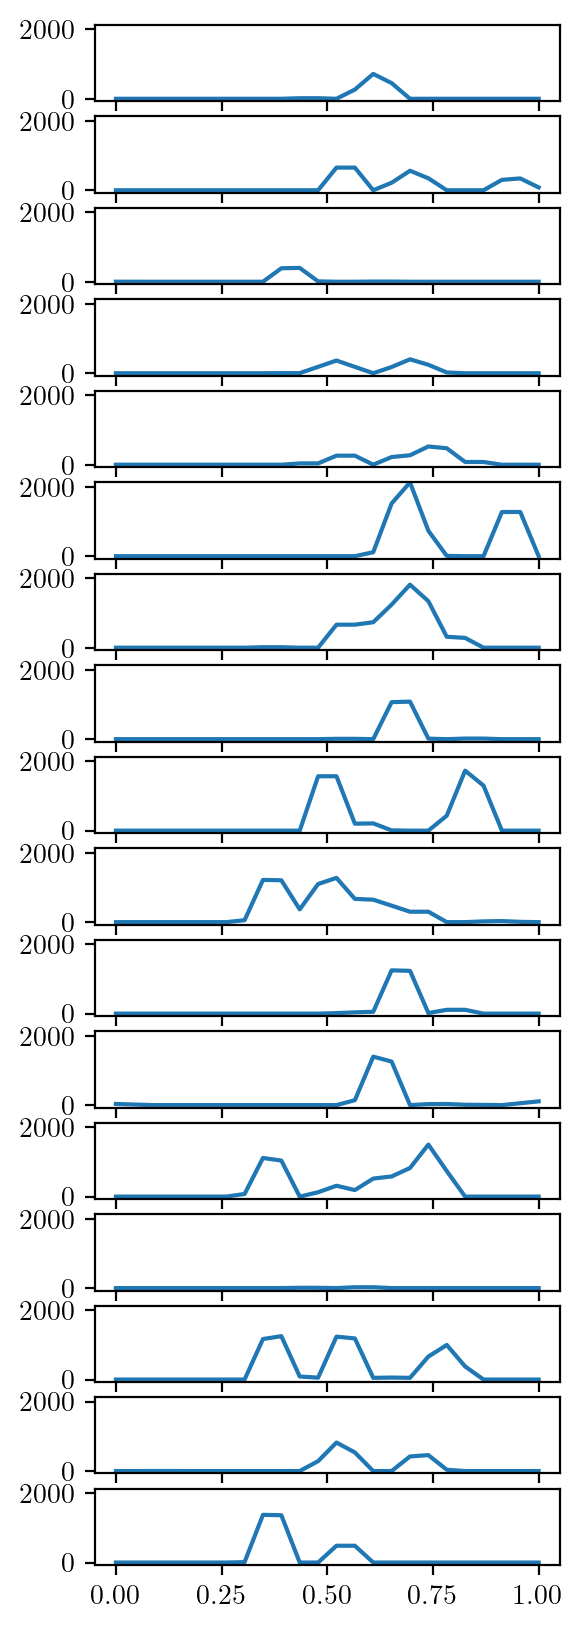

In [290]:
n_timestep = 10
timestep = np.linspace(0, 1, n_timestep)
X_train = []
y_train = []
deriv_cum_steps = np.zeros((n_days, timestep.size))
for idx_day in range(n_days):
    cum_steps_day = np.sum(step_events[idx_day] <= timestep[:, None], axis=1)
    deriv_cum_steps_day =  np.gradient(cum_steps_day, timestep+1) / (timestep.size-1)
    deriv_cum_steps[idx_day] = deriv_cum_steps_day
    # print(np.sum(deriv_cum_steps_day))
    X_train.append(list(timestep))
    y_train.append(list(deriv_cum_steps_day))


fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

In [291]:
class StepTransformer:
    def __init__(self):
        self.step_scaler = MinMaxScaler(feature_range=(1, 10))
        self.lambda_param = None

    def fit_transform(self, step_events):
        all_steps = np.concatenate(step_events)
        all_steps = logit(all_steps)
        all_steps = self.step_scaler.fit_transform(all_steps.reshape(-1, 1)).flatten()
        all_steps, self.lambda_param = stats.boxcox(all_steps)
        return self.transform(step_events)
    
    def _transform(self, step_events):
        X = np.asarray(step_events).reshape(-1, 1)
        return stats.boxcox(self.step_scaler.transform(logit(X)).flatten(), lmbda=self.lambda_param)
        
    def _inv_transform(self, transformed):
        return sigmoid(self.step_scaler.inverse_transform(inv_boxcox(transformed, self.lambda_param).reshape(-1, 1)).flatten())
    
    def transform(self, step_events):
        if isinstance(step_events, list):
            transformed = []
            for day in range(len(step_events)):
                transformed.append(self._transform(step_events[day]))
        else:
            transformed = self._transform(step_events)
        return transformed

    def inverse_transform(self, transformed):
        if not hasattr(self, "lambda_param"):
            raise ValueError("The transformer has not been fitted yet")
        if isinstance(transformed, list):
            inversed = []
            for day in range(len(transformed)):
                inversed.append(self._inv_transform(transformed[day]))
        else:
            inversed = self._inv_transform(transformed)
        return inversed

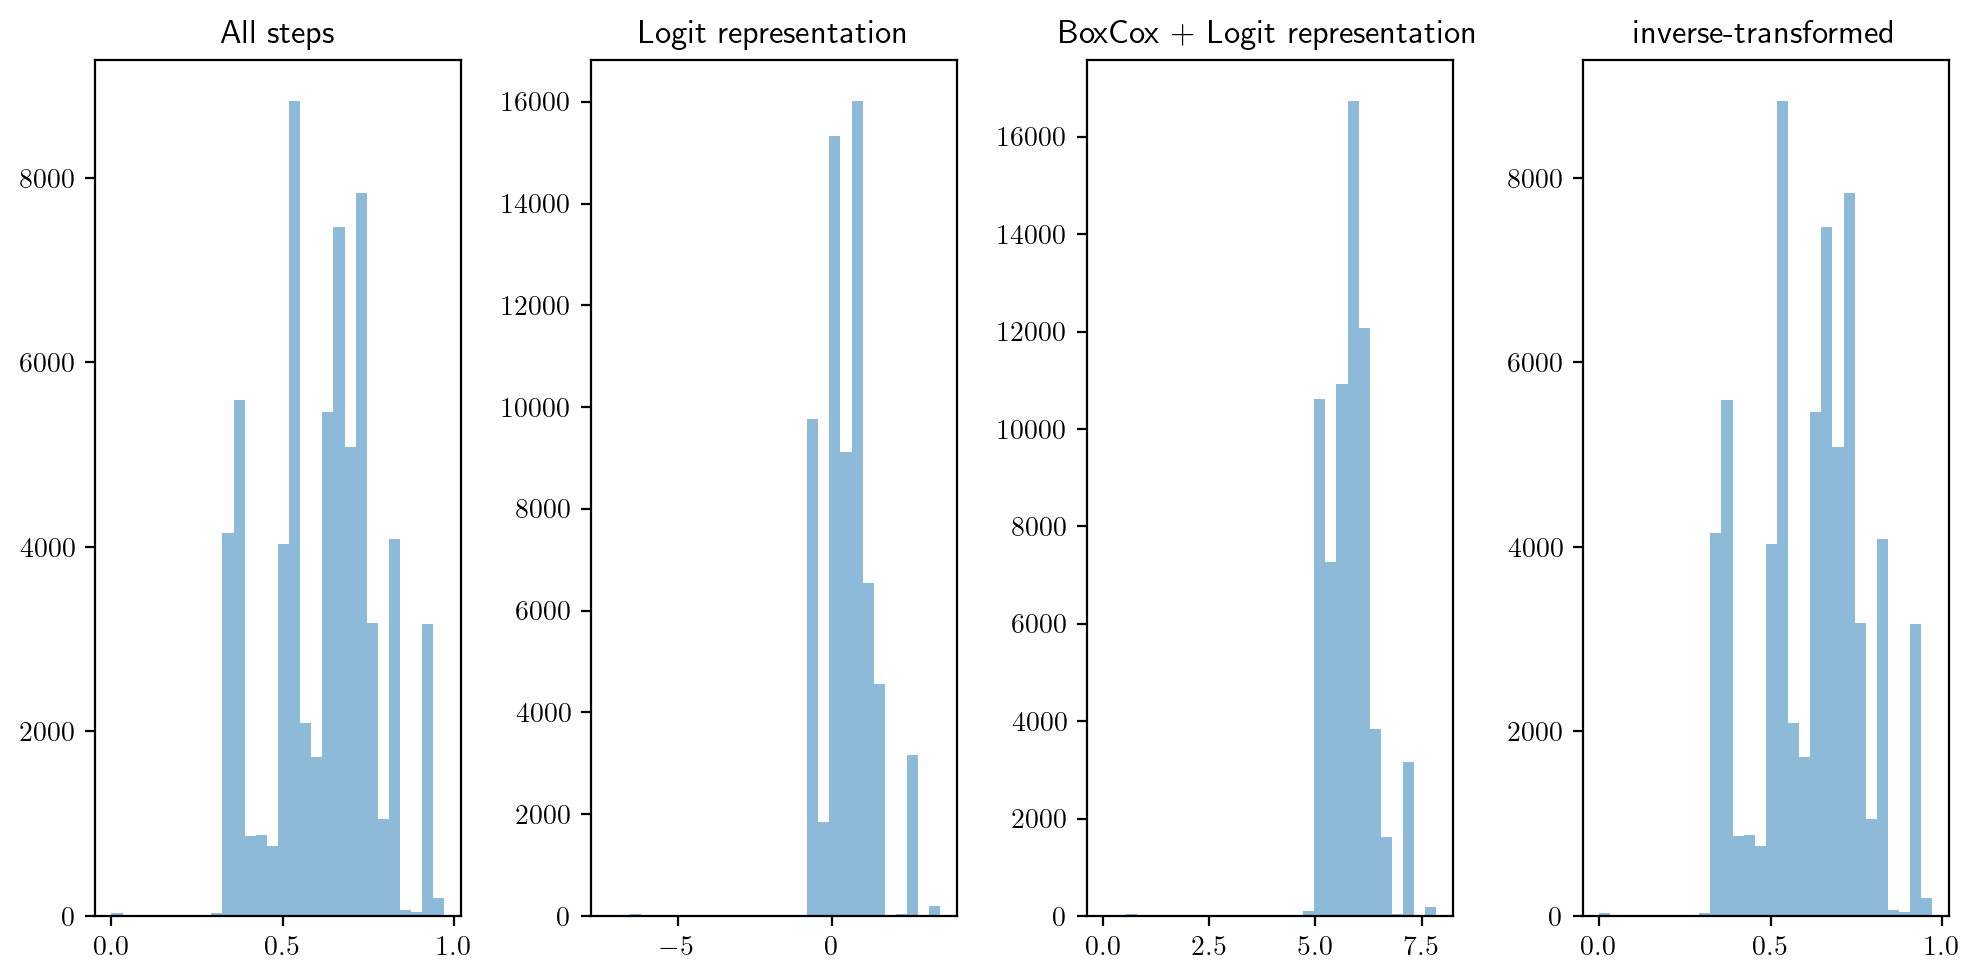

In [292]:
step_transformer = StepTransformer()
transformed_all_steps = step_transformer.fit_transform(step_events)
untransformed_all_steps = step_transformer.inverse_transform(transformed_all_steps)

fig, axes = plt.subplots(ncols=4, figsize=(10, 5))
fig.set_tight_layout(True)

ax = axes[0]
ax.set_title(f"All steps")
ax.hist(np.concatenate(step_events), bins=30, color="C0", alpha=0.5)

ax = axes[1]
ax.set_title("Logit representation")
ax.hist(logit(np.concatenate(step_events)), bins=30, color="C0", alpha=0.5)

ax = axes[2]
ax.set_title("BoxCox + Logit representation")
ax.hist(np.concatenate(transformed_all_steps), bins=30, color="C0", alpha=0.5)

ax = axes[3]
ax.set_title("inverse-transformed")
ax.hist(np.concatenate(untransformed_all_steps), bins=30, color="C0", alpha=0.5);

# Fit model alpha (lowest in hierachy)

In [293]:
class ParamTransformer:
    def __init__(self, step_events):
        self.max_n = max([len(step_events[day]) for day in range(n_days)])
    
    def transform(self, gmm):
        
        # Extract the parameters and transform them 
        transformed_means = gmm.means_.flatten()
        transformed_vars = np.log1p(gmm.covariances_).flatten()
        transformed_weights = logit(gmm.weights_.flatten())
        transformed_n = np.atleast_1d(np.log(X.size / self.max_n))
        
        # Store the transformed parameters
        if n_components == 1:
            features = [transformed_means, transformed_vars, transformed_n]

        else:
            features = [transformed_means, transformed_vars, transformed_weights, transformed_n]
        
        # Concatenate the transformed parameters
        return np.concatenate(features)
        
    def inverse_transform(self, features, n_components):
        
        # Extract the transformed parameters
        transformed_means = features[:n_components]
        transformed_vars = features[n_components:2*n_components]
        if n_components == 1:
            transformed_weights = np.empty(0)
        else:
            transformed_weights = features[2*n_components:-1]
        transformed_n = features[-1]
        
        # Inverse-transform the parameters
        means = transformed_means
        variances = np.expm1(transformed_vars)
        if n_components == 1:
            weights = np.ones(1)
        else:
            weights = sigmoid(transformed_weights) # Inverse of logit
            weights /= np.sum(weights)  # Normalise the weights
        
        n = int(round(np.exp(transformed_n) * self.max_n))
        
        # Store the inverse-transformed parameters
        return {
            "means": means, 
            "variances": variances, 
            "weights": weights, 
            "n": n}

In [294]:
# Define the range of number of components to try
n_model_types = 5
n_components_range = range(1, 1+n_model_types)

# Array to hold the BIC for each number of components
cmp_score = np.zeros((n_days, len(list(n_components_range))))

# Prepare the containers for the 2nd level GMM (GMM Beta) -------
all_features = []  
for n_components in n_components_range:
    if n_components == 1:
        # for each model: per day, logit(mean), log1p(var), n
        all_features.append(np.zeros((n_days, 3)))
    else:
        # for each model: per day, logit(means), log1p(var), logit(coeff)
        all_features.append(np.zeros((n_days, n_components*3+1)))

param_transformer = ParamTransformer(step_events)

# For evaluation purposes, we will also store generated steps
gen_deriv_cum_steps = np.zeros((n_model_types, n_days, n_timestep))

# Store the fitted models
all_alpha_gmm = np.zeros((n_model_types, n_days), dtype=object)

# ------------------------------------------------------------------

for day in tqdm(range(n_days)):
    
    # Get the (transformed) steps for the day
    X = transformed_all_steps[day].reshape(-1, 1)
    
    # Fit a Gaussian Mixture Model for each number of components
    for model, n_components in enumerate(n_components_range):
        
        # Fit the model
        gmm = GaussianMixture(n_components=n_components, random_state=123)
        gmm.fit(X)
        
        # Store the BIC score
        cmp_score[day, model] = gmm.bic(X)
        
        # Store the model
        all_alpha_gmm[model, day] = gmm
        
        # Store the (transformed) parameters (referred to as `features`)
        features = param_transformer.transform(gmm)
        all_features[model][day] = features

        # Generate the steps for the day with the fitted model        
        n = len(X.flatten())
        samples_alpha, _ = gmm.sample(n_samples=n) 
        
        # Inverse-transform the steps
        step_events_day = step_transformer.inverse_transform(samples_alpha).flatten()
        
        # Compute the cumulative steps and the derivative of the cumulative steps to get the activity
        cum_steps_day = np.sum(step_events_day <= timestep[:, None], axis=1)
        deriv_cum_steps_day = np.gradient(cum_steps_day, timestep + 1) / (timestep.size - 1)
        gen_deriv_cum_steps[model, day] = deriv_cum_steps_day

  0%|          | 0/17 [00:00<?, ?it/s]

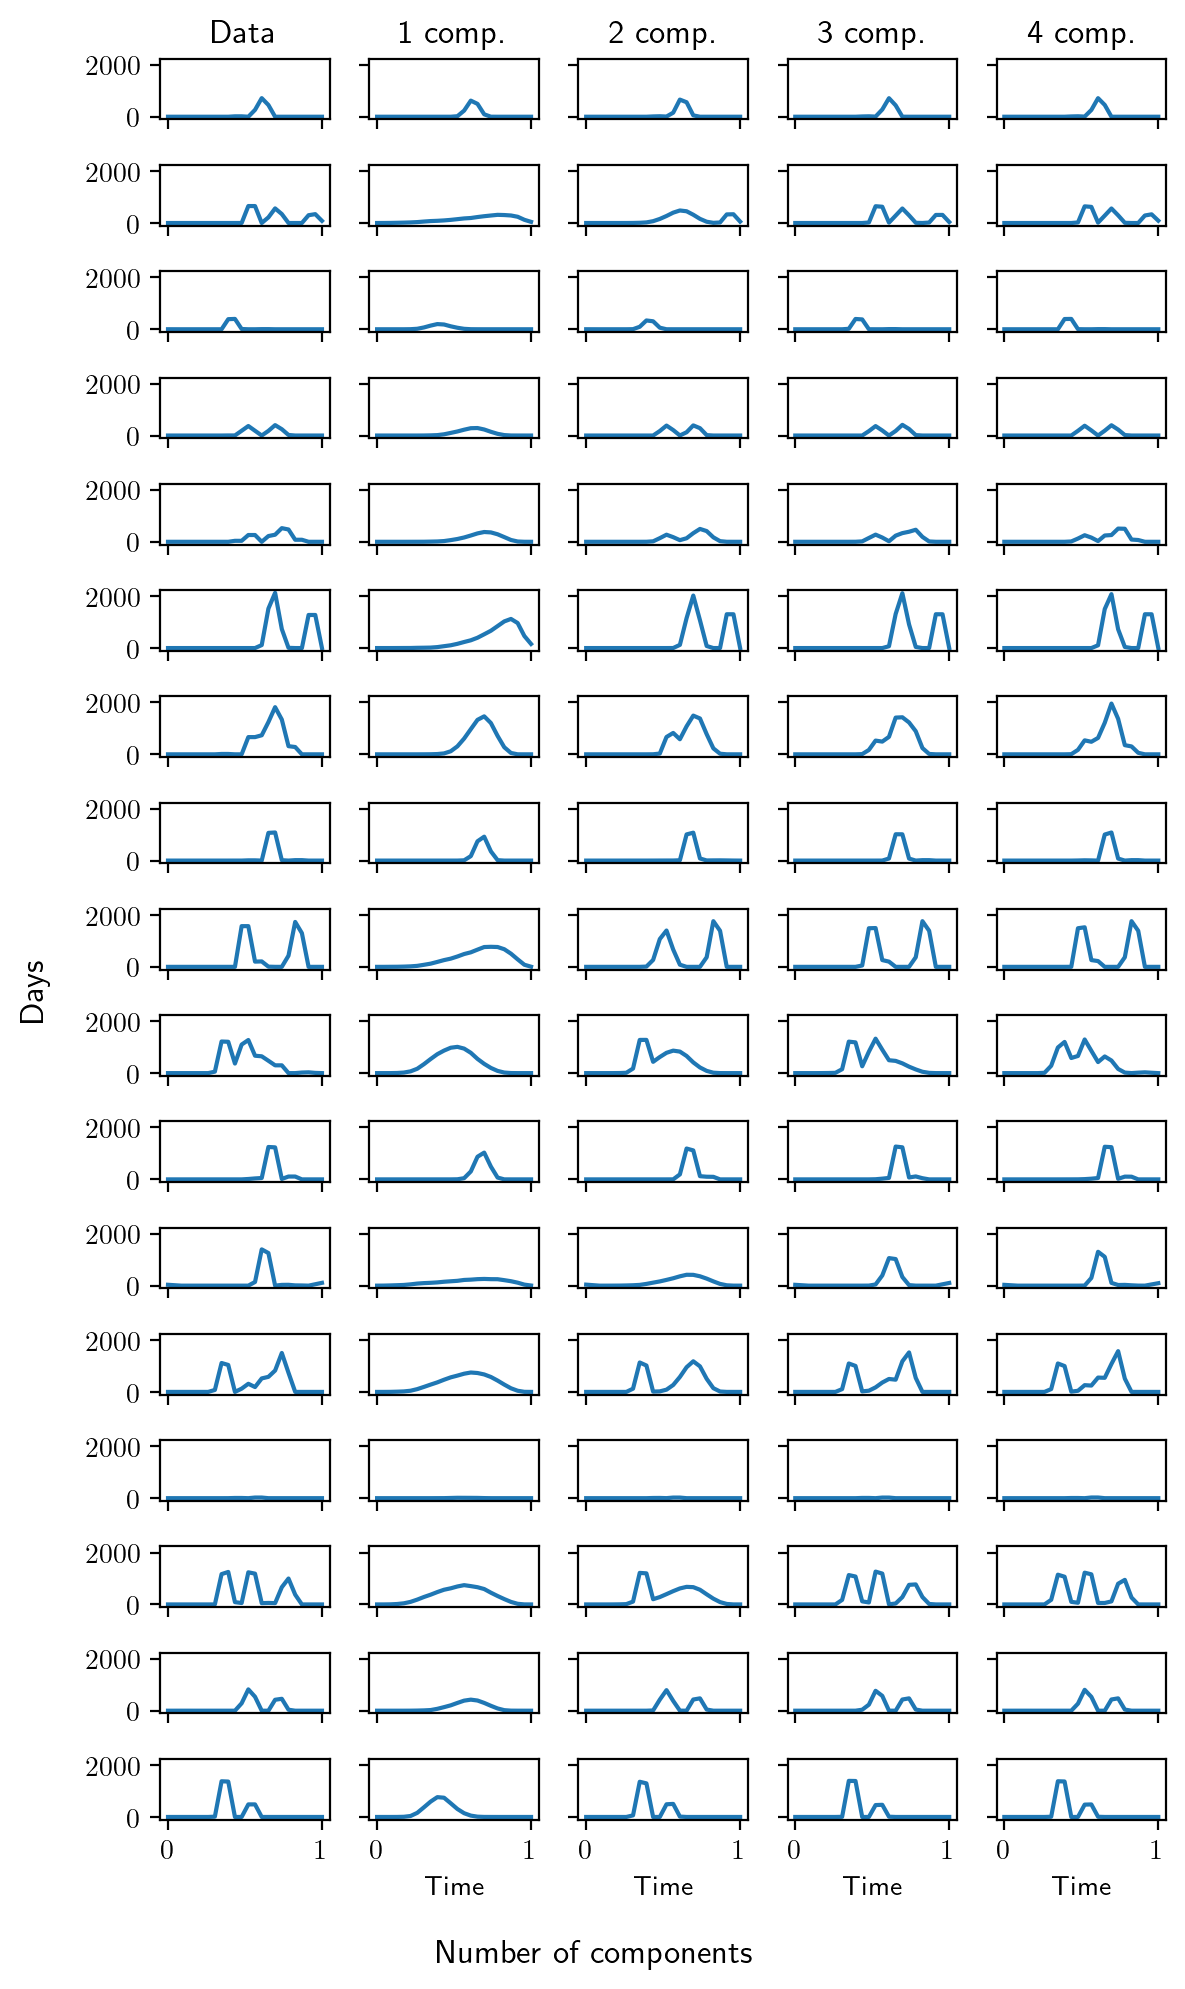

In [295]:
n_model_plot = min(n_model_types, 4)

fig, axes = plt.subplots(
    ncols=n_model_plot+1, 
    nrows=n_days,
    figsize=(6, 10), sharex=True, sharey=True)

fig.set_tight_layout(True)

for day in range(n_days):
    ax = axes[day, 0]
    ax.plot(timestep, deriv_cum_steps[day], color="C0")
    if day == 0:
        ax.set_title("Data")
    for model in range(n_model_plot):
        ax = axes[day, model+1]
        ax.plot(timestep, gen_deriv_cum_steps[model, day], color="C0")
        ax.grid(False)
        if day == 0:
            ax.set_title(f"{n_components_range[model]} comp.")
        elif day == n_days-1:
            ax.set_xlabel("Time")

fig.supxlabel("Number of components")
fig.supylabel("Days");

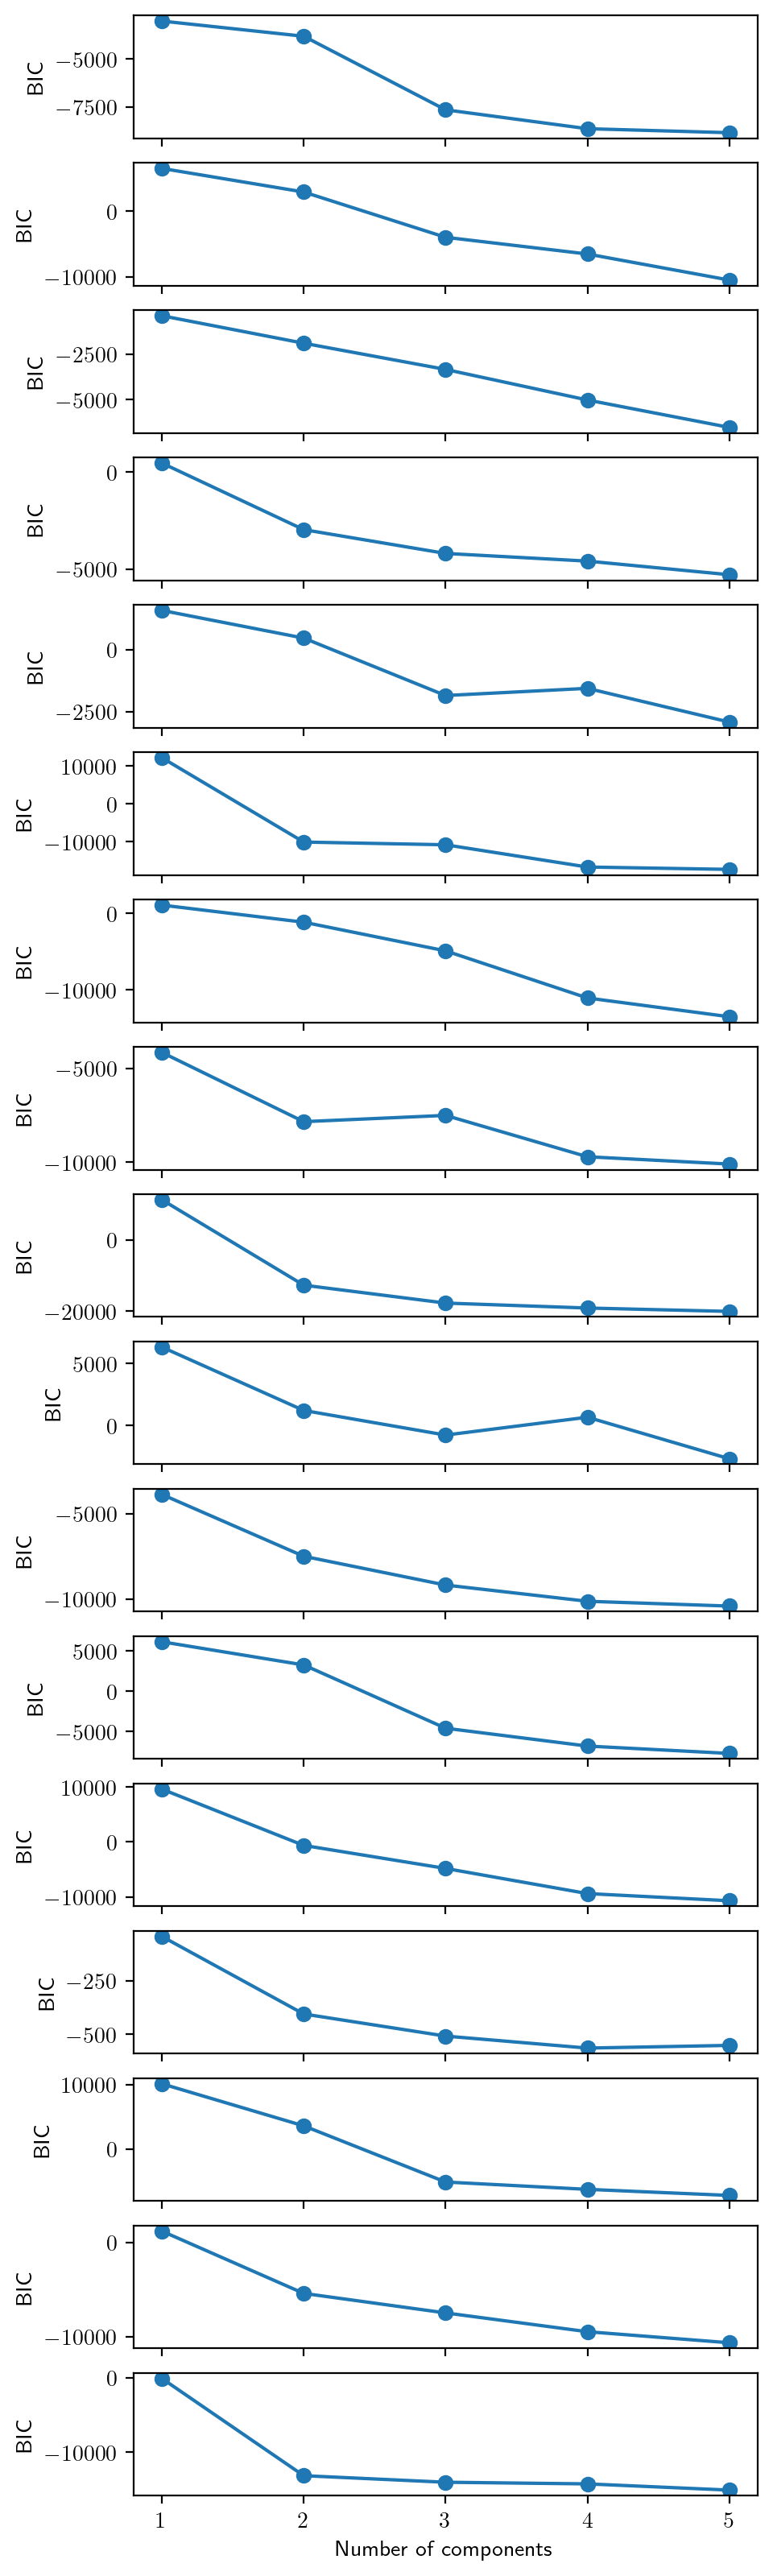

In [296]:
fig, axes = plt.subplots(nrows=n_days, figsize=(5, 20), sharex=True)
for day in range(n_days):
    ax = axes[day]
    ax.plot(n_components_range, cmp_score[day], marker='o')
    if day == n_days-1:(
        ax.set_xlabel('Number of components'))
    # have only integer ticks
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('BIC')

# Test the param transformer

In [297]:
number_of_components_alpha = 3
model = number_of_components_alpha - 1 # 0-indexed
X_train = all_features[model]
# Standardize the data
features_standardiser = StandardScaler()
X_train = features_standardiser.fit_transform(X_train)

models = all_alpha_gmm[model]

for day in range(n_days):
    gmm = models[day]
    means = gmm.means_.flatten()
    vars = gmm.covariances_.flatten()
    weights = gmm.weights_.flatten()
    n = len(step_events[day])
    
    print("means", means)
    print("vars", vars)
    print("weights", weights)
    print("n", n)
    
    X = X_train[day]
    un_standardised_feat = features_standardiser.inverse_transform(X.reshape(1, -1)).flatten()
    # Get back the GMM parameters by inverse-transforming the features
    params = param_transformer.inverse_transform(un_standardised_feat, number_of_components_alpha)
    
    print("means", params["means"])
    print("vars", params["variances"])
    print("weights", params["weights"])
    print("n", params["n"])
    print("-----")
    
    

means [5.83016748 5.70666839 5.36119917]
vars [2.04143293e-04 1.06811243e-05 1.80190977e-04]
weights [0.61638225 0.36177474 0.021843  ]
n 1465
means [5.83016748 5.70666839 5.36119917]
vars [2.04143293e-04 1.06811243e-05 1.80190977e-04]
weights [0.61638225 0.36177474 0.021843  ]
n 1465
-----
means [6.00904334 7.32277788 5.51633313]
vars [0.00473053 0.02734136 0.00021668]
weights [0.36118252 0.21915167 0.41966581]
n 3112
means [6.00904334 7.32277788 5.51633313]
vars [0.00473053 0.02734136 0.00021668]
weights [0.36118252 0.21915167 0.41966581]
n 3112
-----
means [5.16772502 0.20255369 5.77496668]
vars [8.38946688e-04 1.00000000e-06 1.00009349e-06]
weights [0.98638614 0.00123762 0.01237624]
n 808
means [5.16772502 0.20255369 5.77496668]
vars [8.38946688e-04 1.00000000e-06 1.00009349e-06]
weights [0.98638614 0.00123762 0.01237624]
n 808
-----
means [6.09019065 5.49318025 5.97453735]
vars [1.86137501e-03 1.01214873e-03 1.87964071e-05]
weights [0.30921363 0.4665404  0.22424596]
n 1584
means [

# Fit model beta (second in hierarchy)

In [298]:
number_of_components_alpha = 3
model = number_of_components_alpha - 1 # 0-indexed
X_train = all_features[model]
# Standardize the data
features_standardiser = StandardScaler()
X_train = features_standardiser.fit_transform(X_train)
print(X_train.shape)

n_components_range_beta = range(1, 18)

#TODO: try non-diagonal covariance
# 3. Fit a 3rd level GMM with the bic scores
all_beta_gmm = [GaussianMixture(n_components=n_components).fit(X_train) for n_components in n_components_range_beta]
all_beta_scores = [gmm.bic(X_train) for gmm in all_beta_gmm]

(17, 10)


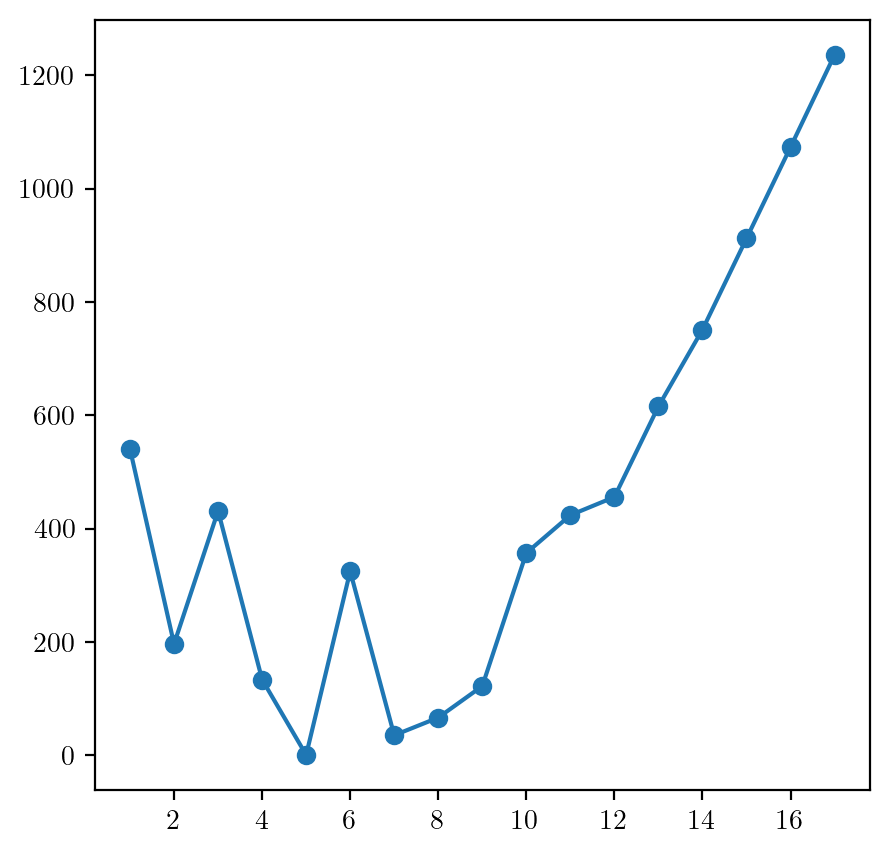

In [299]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(n_components_range_beta, all_beta_scores, marker='o')
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [300]:
# 4. Choose the best model
best_beta_idx = np.argmin(all_beta_scores)
best_beta_gmm = all_beta_gmm[best_beta_idx]

n_sample_beta = 10000 # This will be number of days that will be generated

samples_beta, _  = best_beta_gmm.sample(n_samples=n_sample_beta)

In [301]:
np.random.seed(1234)

deriv_cum_steps = np.zeros((n_sample_beta, timestep.size))

for day in range(n_sample_beta):
    
    # Choose with type of model to use ---------------------------
    
    # Using the alpha-model, draw a model type for model-gamma according to the goodness of fit scores
    
    # Un-standardise the features
    X = samples_beta[day].reshape(1, -1)
    un_standardised_feat = features_standardiser.inverse_transform(X).flatten()
    # Get back the GMM parameters by inverse-transforming the features
    params = param_transformer.inverse_transform(un_standardised_feat, number_of_components_alpha)
    
    # Set up the gamma-model
    gmm = GaussianMixture(n_components=number_of_components_alpha)
    gmm.means_ = params["means"].reshape(-1, 1)
    gmm.covariances_ = params["variances"].reshape(-1, 1, 1)
    gmm.weights_ = params["weights"]
    
    # Get the number of samples to draw (= number of steps)
    n = params["n"]
    
    # Generate the (transformed) steps (ignore the 'covariance is not symmetric positive-semidefinite.' warning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    samples_alpha, _ = gmm.sample(n_samples=n) 
    warnings.filterwarnings("default", category=RuntimeWarning)
    
    # Inverse-transform the steps
    step_events_day = step_transformer.inverse_transform(samples_alpha).flatten()
    
    # Compute the cumulative steps and the derivative of the cumulative steps to get the activity
    cum_steps_day = np.sum(step_events_day <= timestep[:, None], axis=1)
    deriv_cum_steps_day = np.gradient(cum_steps_day, timestep + 1) / (timestep.size - 1)
    deriv_cum_steps[day] = deriv_cum_steps_day 

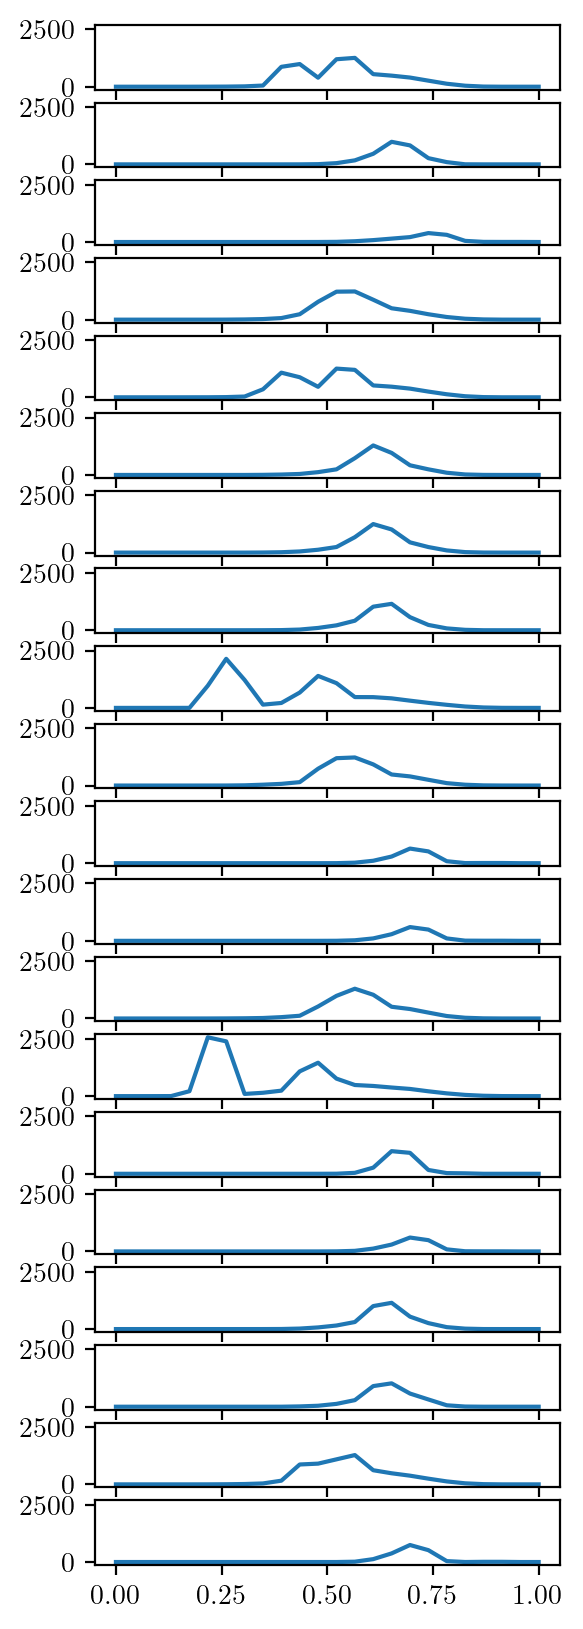

In [302]:
fig, axes = plt.subplots(min(deriv_cum_steps.shape[0], 20), figsize=(3, 10), sharex=True, sharey=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    # ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

In [303]:
def square_exponential_kernel(x, alpha, length):
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    sq_dist = np.sum(x**2, 1).reshape(-1, 1) + np.sum(x**2, 1) - 2 * np.dot(x, x.T)
    return alpha**2 * np.exp(-0.5 * sq_dist / length**2)

In [534]:
mu = 60000 + 400000*np.cos(3 * (timestep - 2))
mu[timestep > 0.4] = - 1000000 
# mu = - 5000 + 10000*1/(1 + np.exp(1000*(timestep- 0.5)))
sigma = square_exponential_kernel(timestep, 50,  0.5)
rng = np.random.default_rng(1234)
push_effect = rng.multivariate_normal(mu, sigma, size=n_sample_beta)

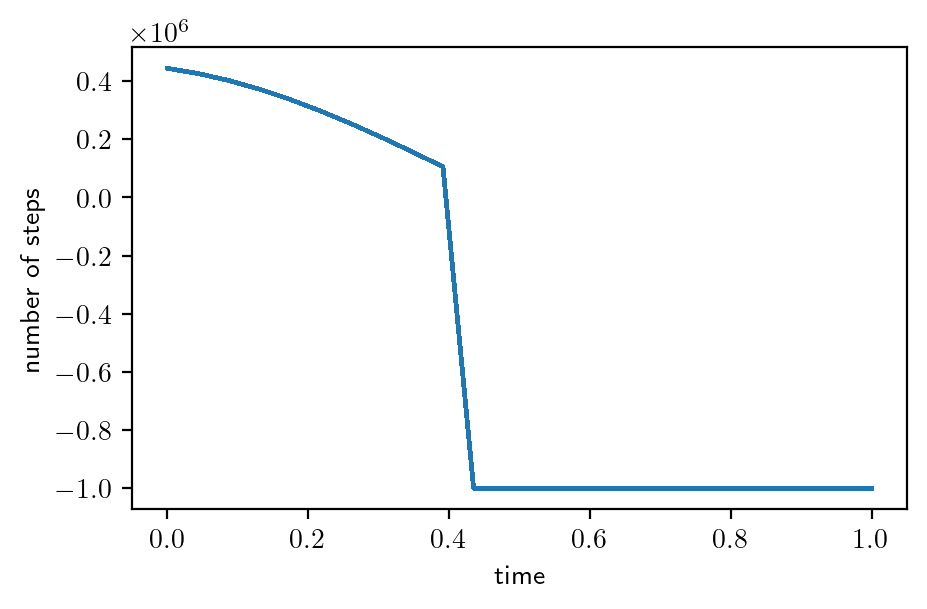

In [535]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(timestep, push_effect.T, color="C0", alpha=0.01)
ax.set_xlabel("time")
ax.set_ylabel("number of steps");

In [536]:
# activity = np.zeros((2,) + tuple(deriv_cum_steps.shape))
# activity[0] = deriv_cum_steps
# activity[1] = deriv_cum_steps + push_effect[:deriv_cum_steps.shape[0]]
# activity[activity < 0] = 0

In [537]:
deriv_cum_steps.shape

(10000, 24)

In [538]:
push_effect.shape

(10000, 24)

In [539]:
timestep.size

24

In [540]:
actions =  np.random.choice([0, 1], size=(n_sample_beta, timestep.size-1))
combined = deriv_cum_steps.copy()
combined[:, 1:] += actions * push_effect[:, 1:]   
combined[combined < 0] = 0

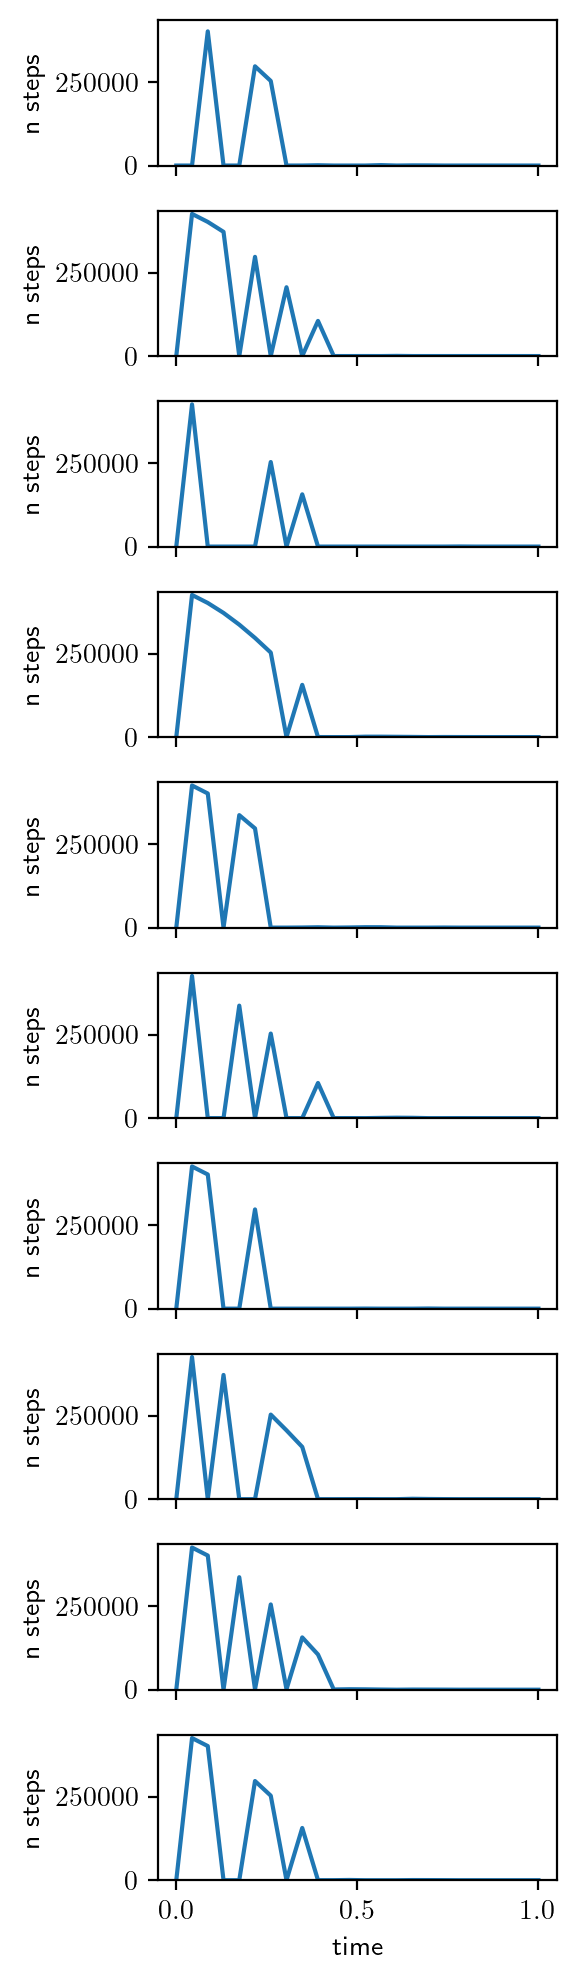

In [541]:
# Plot the activity
n_samples = min(combined.shape[0], 10) # Number of days
fig, axes = plt.subplots(n_samples, figsize=(3, 10), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(timestep, combined[i], color="C0")
    ax.set_ylim(np.min(combined) - 100, np.max(combined) + 100)
    ax.grid(False)
    if i == len(axes) - 1:
        ax.set_xlabel("time")
    ax.set_ylabel("n steps")
fig.tight_layout()

In [542]:
n_action = 2
n_velocity = 60
# velocity = np.concatenate((np.zeros(1), np.geomspace(2, np.max(combined)+1, n_velocity-1)))
velocity =np.linspace(0, np.max(combined)+1, n_velocity)
velocity

array([     0.        ,   7394.08828891,  14788.17657782,  22182.26486673,
        29576.35315565,  36970.44144456,  44364.52973347,  51758.61802238,
        59152.70631129,  66546.7946002 ,  73940.88288911,  81334.97117802,
        88729.05946694,  96123.14775585, 103517.23604476, 110911.32433367,
       118305.41262258, 125699.50091149, 133093.5892004 , 140487.67748932,
       147881.76577823, 155275.85406714, 162669.94235605, 170064.03064496,
       177458.11893387, 184852.20722278, 192246.29551169, 199640.38380061,
       207034.47208952, 214428.56037843, 221822.64866734, 229216.73695625,
       236610.82524516, 244004.91353407, 251399.00182299, 258793.0901119 ,
       266187.17840081, 273581.26668972, 280975.35497863, 288369.44326754,
       295763.53155645, 303157.61984536, 310551.70813428, 317945.79642319,
       325339.8847121 , 332733.97300101, 340128.06128992, 347522.14957883,
       354916.23786774, 362310.32615666, 369704.41444557, 377098.50273448,
       384492.59102339, 3

In [543]:
# Add one bin for infinity
bins = np.concatenate((velocity, np.full(1, np.inf)))
drv = np.clip(combined, bins[0], bins[-1])
v_idx = np.digitize(drv, bins, right=False) - 1
print(v_idx.shape)

(10000, 24)


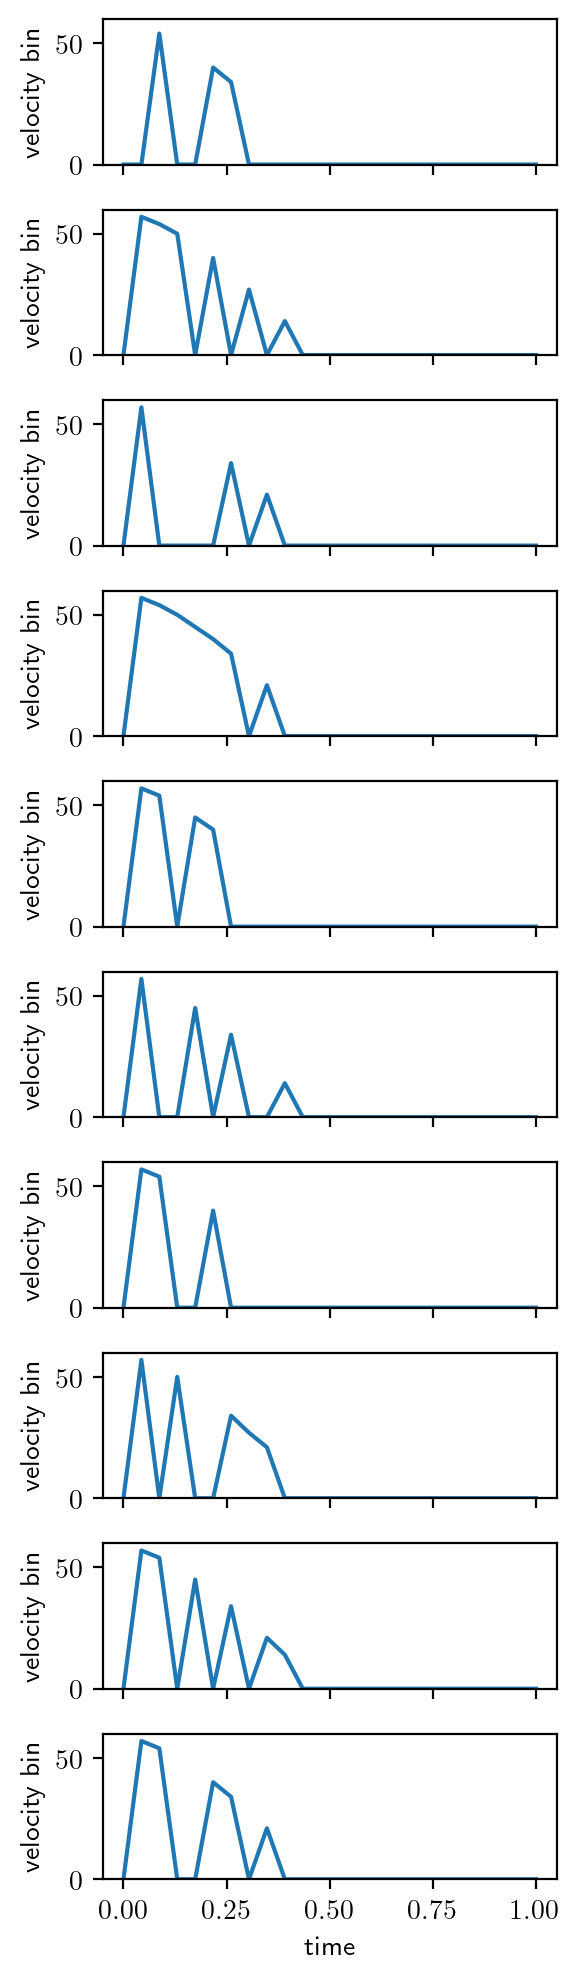

In [544]:
# Plot the activity
n_samples = min(combined.shape[0], 10) # Number of days
fig, axes = plt.subplots(n_samples, figsize=(3, 10), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(timestep, v_idx[i], color="C0")
    ax.set_ylim(0, n_velocity)
    ax.grid(False)
    if i == len(axes) - 1:
        ax.set_xlabel("time")
    ax.set_ylabel("velocity bin")
fig.tight_layout()

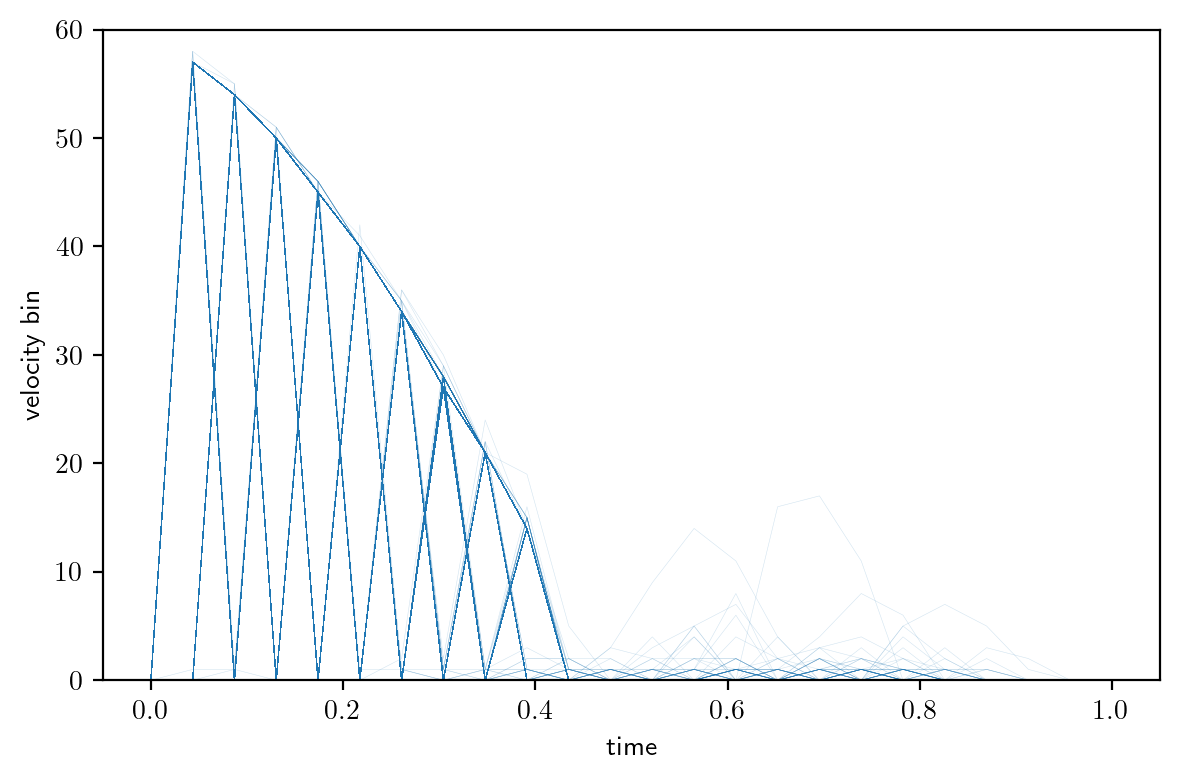

In [545]:
# Plot the activity
n_samples = min(v_idx.shape[0], 10000) # Number of days
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(n_samples):
    ax.plot(timestep, v_idx[i], color="C0", alpha=0.2, linewidth=0.2)
ax.set_ylim(0, n_velocity)
ax.grid(False)
ax.set_xlabel("time")
ax.set_ylabel("velocity bin")
fig.tight_layout()

In [546]:
alpha_atvv = np.zeros((n_action, timestep.size-1, velocity.size, velocity.size))
for sample in range(n_sample_beta):
    for t in range(timestep.size - 1):
        alpha_atvv[actions[sample, t], t, v_idx[sample, t], v_idx[sample, t + 1]] += 1

In [547]:
print(alpha_atvv.sum())

230000.0


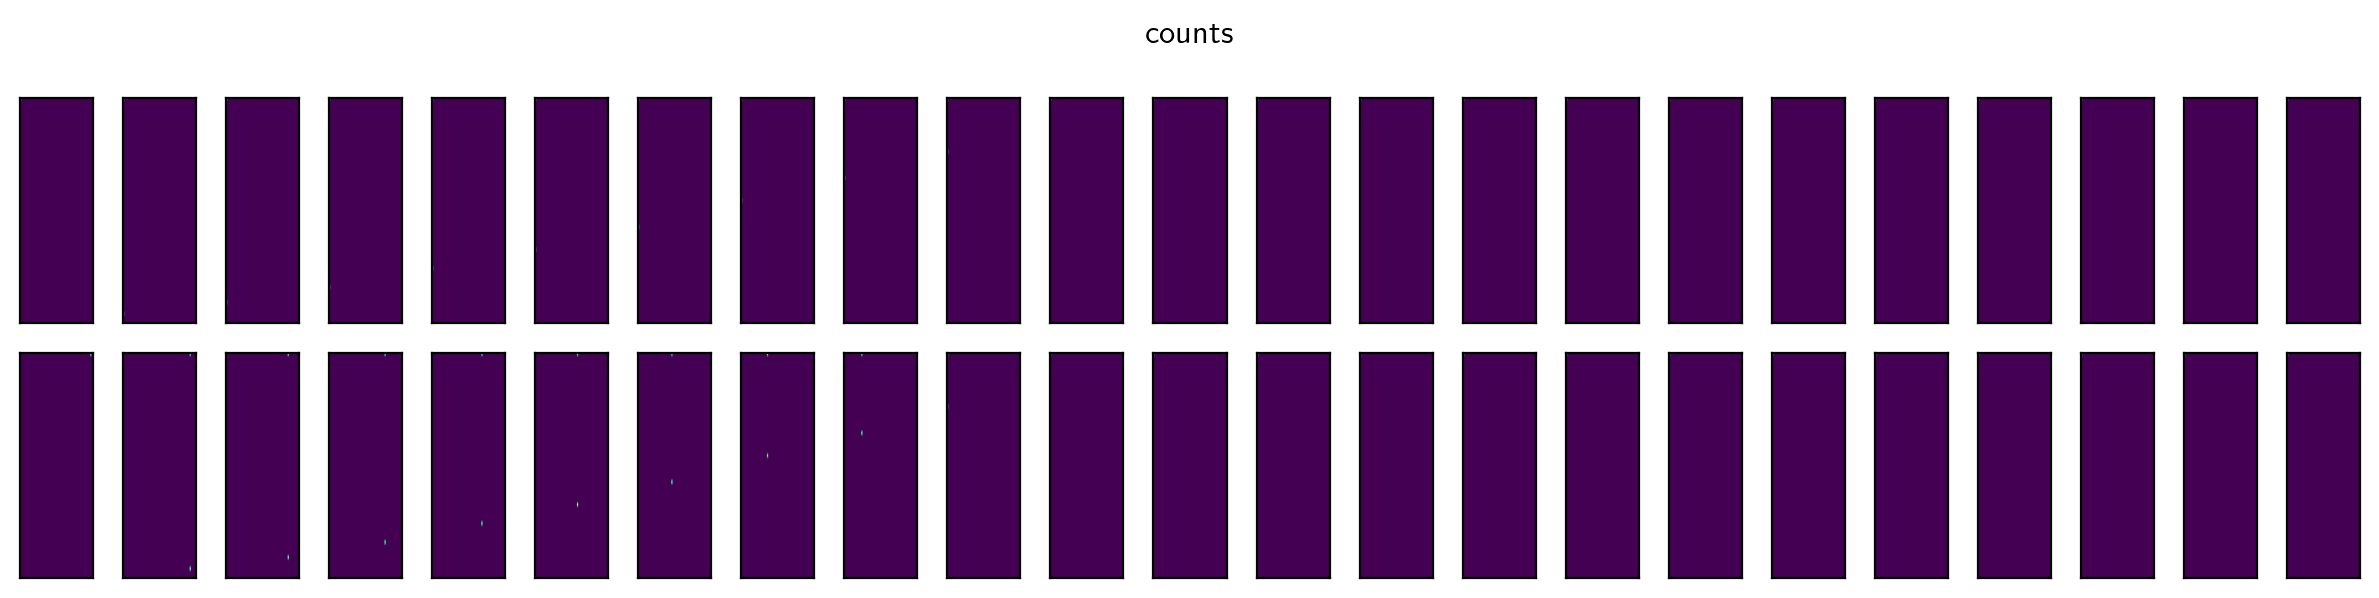

In [548]:
plot.q(alpha_atvv, 
       title="counts", 
       figsize=(12, 3), 
       cmap="viridis", between_0_and_1=False)

In [549]:
# Add some jitter
jitter = 1
alpha_atvv += jitter

In [550]:
# Compute expected probabilities
transition_velocity_atvv = normalize_last_dim(alpha_atvv) # Expected value given Dirichlet distribution parameterised by alpha

# Make sure that all probabilities sum to (more or less) one
np.allclose(np.sum(transition_velocity_atvv, axis=-1), 1) 

True

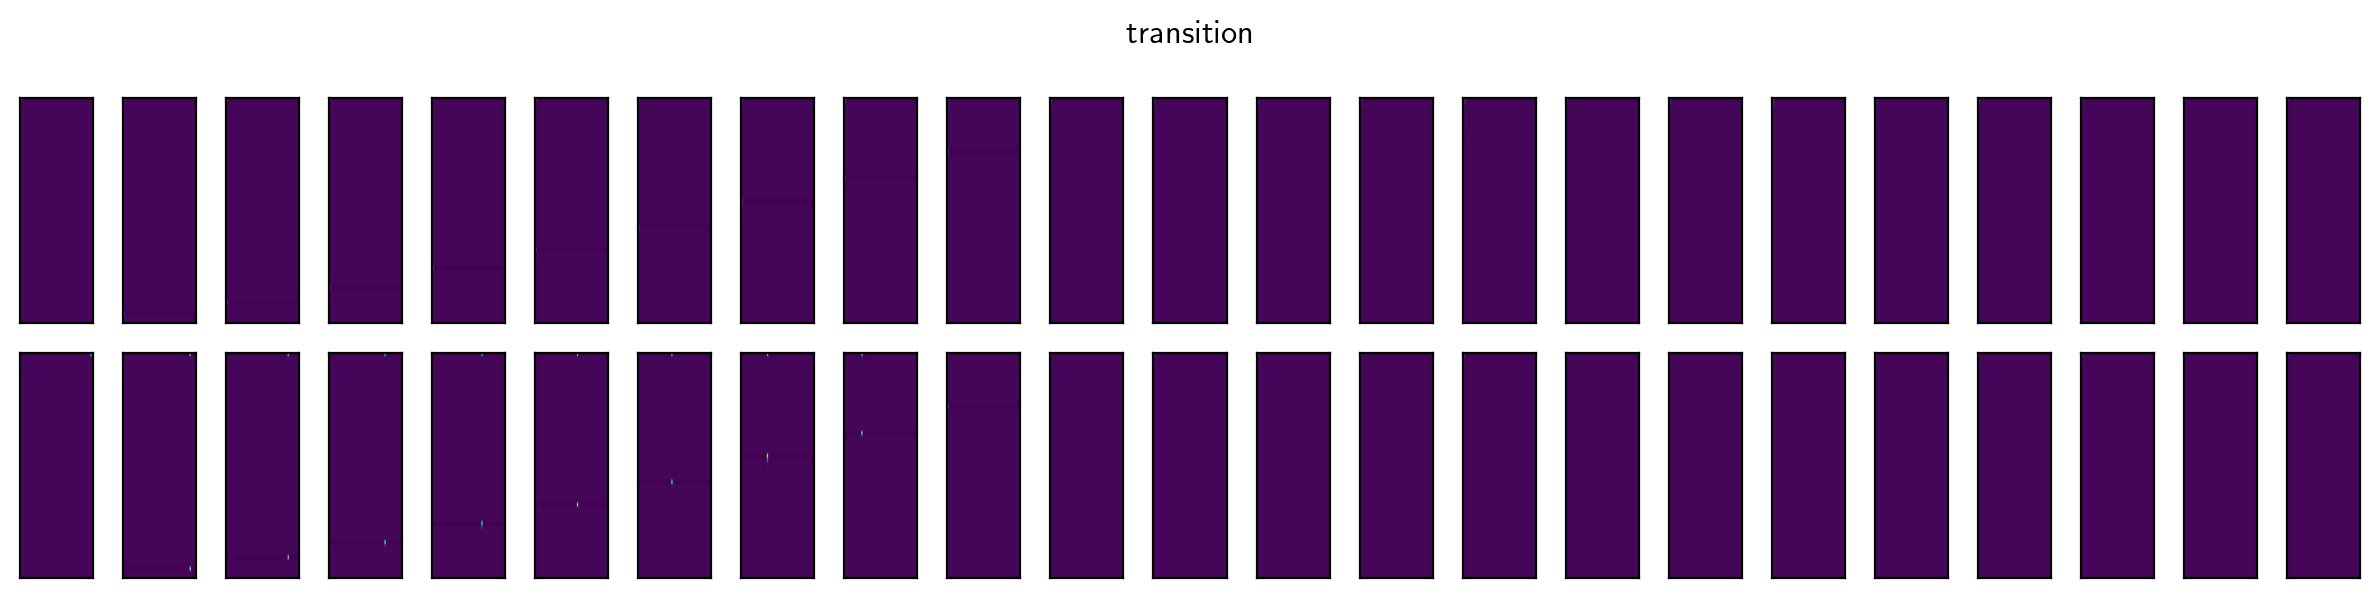

In [551]:
plot.q(transition_velocity_atvv, 
       title="transition", 
       figsize=(12, 3), 
       cmap="viridis", between_0_and_1=True)

In [553]:
sum_steps = np.sum(combined, axis=1)
position = np.linspace(0, np.max(sum_steps)*1.2, 30)
# Compute position transition matrix
sigma_transition_position = 2000
tr = np.zeros((position.size, velocity.size, position.size))
for p_idx, p in enumerate(position):
    for v_idx, v in enumerate(velocity):
        dist = stats.norm.pdf(position, loc=p + v, scale=sigma_transition_position)
        if np.sum(dist) == 0:
            if p + v < 0:
                dist[0] = 1
            elif p + v > position[-1]:
                dist[-1] = 1 # All weight on greatest position  
            else:
                print(f"bounds: {position[0]}, {position[1]}")
                print(f"p+v: {p+v}")
                raise ValueError("This should not happen, try increasing 'sigma_transition_position'")
        tr[p_idx, v_idx, :] = dist
        
transition_position_pvp = normalize_last_dim(tr)

# Make sure that all probabilities sum to (more or less) one
np.allclose(np.sum(transition_position_pvp, axis=-1), 1) 

True

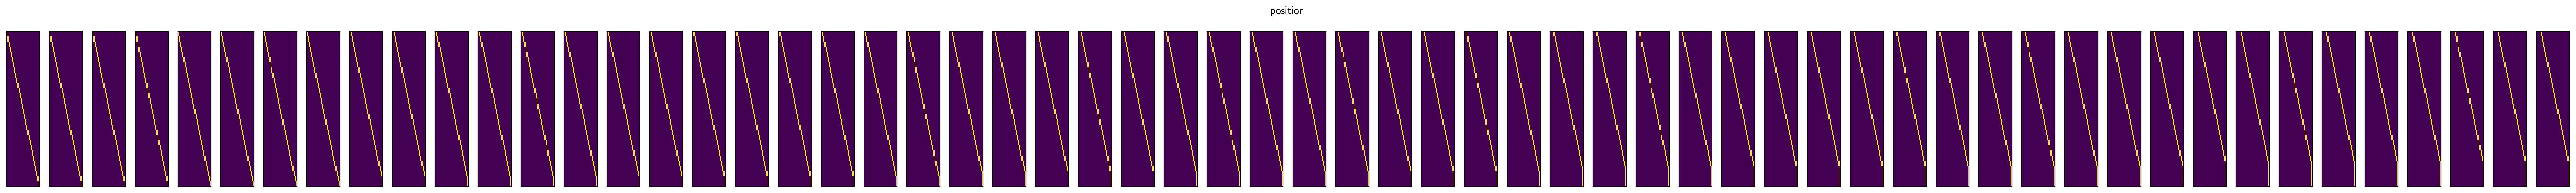

In [554]:
plot.q(transition_position_pvp, "position", (40, 3))

In [555]:
# Remove last timestep as we don't have any data for it
timestep = timestep[:n_timestep] # Remove last timestep

# Shorcuts
n_position = position.size
n_velocity = velocity.size
n_timestep = timestep.size

# Compute preferences
log_prior = np.log(softmax(np.arange(n_position))) # Log prior over position

print(n_timestep, n_position, n_velocity)

24 30 60


In [556]:
# from model.ball_base_model import *

# Pragmatic values: demonstrate that it works for one timestep

In [557]:
v_idx = 0
pos_idx = 0
t_idx = 2

qv = np.zeros(n_velocity)
qv[v_idx] = 1.
qp = np.zeros(n_position)
qp[pos_idx] = 1.

qvs = np.zeros((n_action, n_velocity))
qps = np.zeros((n_action, n_position))
for action_idx, a in enumerate(range(n_action)):
    
    print(action_idx)

    qv_new = qv @ transition_velocity_atvv[a, t_idx, :, :]
    qp_new = qp @ (qv_new @ transition_position_pvp)
    qvs[action_idx] = qv_new
    qps[action_idx] = qp_new

pragmatic = np.sum(qps * log_prior, axis=1)
print("pragmatic values", pragmatic)

e_v = np.zeros(2)
for a in range(2):
    e_v[a] = np.average(velocity, weights=transition_velocity_atvv[a, t_idx, v_idx, :])
print("expected velocities", e_v)

0
1
pragmatic values [-29.41011612 -26.47954068]
expected velocities [  5166.81258246 366198.79376145]


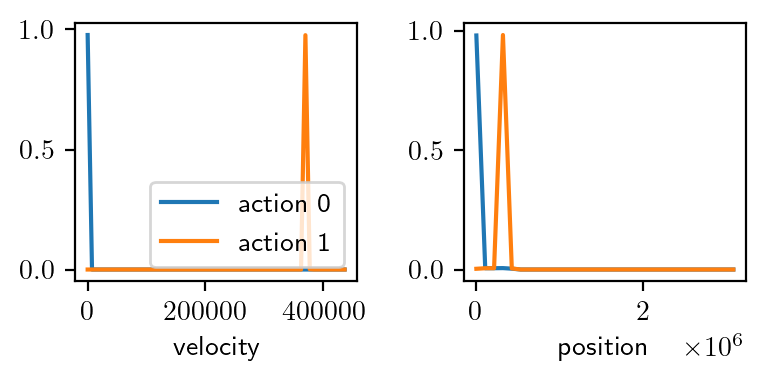

In [558]:
fig, axes = plt.subplots(figsize=(4, 2), ncols=2)

ax = axes[0]
for action_idx, a in enumerate(range(n_action)):
    ax.plot(velocity, qvs[action_idx], label=f"action {a}")

ax.set_xlabel("velocity")
ax.legend(loc="lower right")

ax = axes[1]
for action_idx, a in enumerate(range(n_action)):
    ax.plot(position, qps[action_idx], label=f"action {a}")

ax.set_xlabel("position")
plt.tight_layout()

# Pragmatic values: demonstrate that it works for a run

In [559]:
print(timestep)

[0.         0.04347826 0.08695652 0.13043478 0.17391304 0.2173913
 0.26086957 0.30434783 0.34782609 0.39130435 0.43478261 0.47826087
 0.52173913 0.56521739 0.60869565 0.65217391 0.69565217 0.73913043
 0.7826087  0.82608696 0.86956522 0.91304348 0.95652174 1.        ]


In [560]:
print(transition_velocity_atvv.shape)

(2, 23, 60, 60)


In [561]:
horizon = 1
n_sample_run = 100

# For logs
hist_pos, hist_vel = np.zeros((n_sample_run, timestep.size - 1)), np.zeros((n_sample_run, timestep.size-1))

# For each sample...
for sample in range(n_sample_run):

    pos_idx = np.absolute(position).argmin()  # Something close to 0
    v_idx = np.absolute(velocity).argmin() # Something close to 0

    np.random.seed(1234 + sample*123)

    for t_idx in range(timestep.size - 1):

        h = min(horizon, timestep.size - 1 - t_idx)
        action_plan = list(itertools.product(range(n_action), repeat=h))

        pragmatic = np.zeros(len(action_plan))
        for ap_index, ap in enumerate(action_plan):

            qvs = np.zeros((h, n_velocity))
            qps = np.zeros((h, n_position))

            qv = np.zeros(n_velocity)
            qv[v_idx] = 1.
            qp = np.zeros(n_position)
            qp[pos_idx] = 1.

            for h_idx in range(h):
                a = ap[h_idx]
                rollout_t_index = t_idx + h_idx
                qv = qv @ transition_velocity_atvv[a, rollout_t_index, :, :]
                qp = qp @ (qv @ transition_position_pvp)
                qvs[h_idx] = qv
                qps[h_idx] = qp

            pragmatic[ap_index] = np.sum(qps @ log_prior)

        a = np.random.choice(
            np.arange(len(action_plan))
            [pragmatic == pragmatic.max()])

        v_idx = np.random.choice(np.arange(n_velocity), p=transition_velocity_atvv[a, t_idx, v_idx, :])
        pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])
        
        # This is actually the position at the end of the timestep
        hist_pos[sample, t_idx] = position[pos_idx]
        hist_vel[sample, t_idx] = velocity[v_idx]

run = {
    "policy": "af-pragmatic", 
    "position": hist_pos, 
    "velocity": hist_vel
}

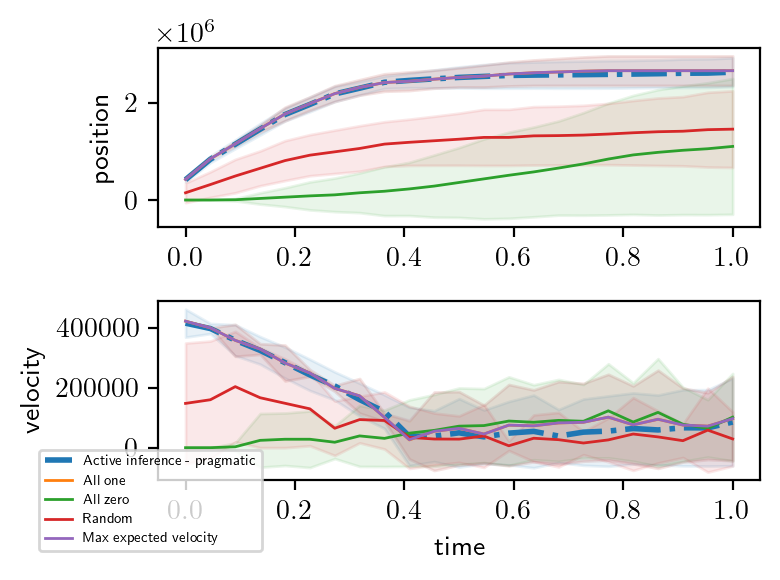

In [562]:
baselines = baseline.run(transition_velocity_atvv=transition_velocity_atvv, 
                         transition_position_pvp=transition_position_pvp, timestep=timestep, position=position, velocity=velocity)
plot.runs(run, *baselines)

# Epistemic value

### Learning the model (= inferring the transition) using a RANDOM policy

In [126]:
all_hist_err = {}
policies_err = []

In [128]:
n_episode = 150
n_sample_run = 20
hist_err = np.zeros((n_sample_run, n_episode*(n_timestep)))
hist_mean_ent = np.zeros_like(hist_err)

for sample in range(n_sample_run):
    
    # Initialize alpha
    alpha_atvv = np.zeros((n_action, n_timestep, n_velocity, n_velocity)) + np.finfo(np.float64).eps

    if sample == 0:
        error = np.mean(np.absolute(transition_velocity_atvv - normalize_last_dim(alpha_atvv)))
        print(f"Initial error {error:.4f}")

    epoch = 0
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin() # Something close to 0

        action_plan = np.random.randint(n_action, size=n_timestep)

        for t_idx in range(n_timestep):

            # Pick new action and draw new velocity
            a = action_plan[t_idx]
            new_v_index = np.random.choice(
                np.arange(n_velocity), 
                p=transition_velocity_atvv[a, t_idx, v_idx, :])

            # Update alpha
            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            alpha_atvv[a, t_idx, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])

            # Log
            error = np.mean(np.absolute(transition_velocity_atvv - normalize_last_dim(alpha_atvv)))
            hist_err[sample, epoch] = error
            mean_ent = np.mean(np.sum(-alpha_atvv * np.log(alpha_atvv + 1e-16), axis=-1))
            hist_mean_ent[sample, epoch] = mean_ent
            
            # Increment epoch counter
            epoch += 1

    print(f"[Sample {sample+1:02d}/{n_sample_run}] Error after {epoch} epochs {error:.4f}")

run_random = {"policy": "random", "error": hist_err, "mean_ent": hist_mean_ent}

Initial error 0.0190
[Sample 01/20] Error after 1350 epochs 0.0544
[Sample 02/20] Error after 1350 epochs 0.0560
[Sample 03/20] Error after 1350 epochs 0.0563
[Sample 04/20] Error after 1350 epochs 0.0551
[Sample 05/20] Error after 1350 epochs 0.0558
[Sample 06/20] Error after 1350 epochs 0.0547
[Sample 07/20] Error after 1350 epochs 0.0544
[Sample 08/20] Error after 1350 epochs 0.0540
[Sample 09/20] Error after 1350 epochs 0.0536
[Sample 10/20] Error after 1350 epochs 0.0553
[Sample 11/20] Error after 1350 epochs 0.0546
[Sample 12/20] Error after 1350 epochs 0.0528
[Sample 13/20] Error after 1350 epochs 0.0534
[Sample 14/20] Error after 1350 epochs 0.0528
[Sample 15/20] Error after 1350 epochs 0.0534
[Sample 16/20] Error after 1350 epochs 0.0535
[Sample 17/20] Error after 1350 epochs 0.0551
[Sample 18/20] Error after 1350 epochs 0.0559
[Sample 19/20] Error after 1350 epochs 0.0543
[Sample 20/20] Error after 1350 epochs 0.0565


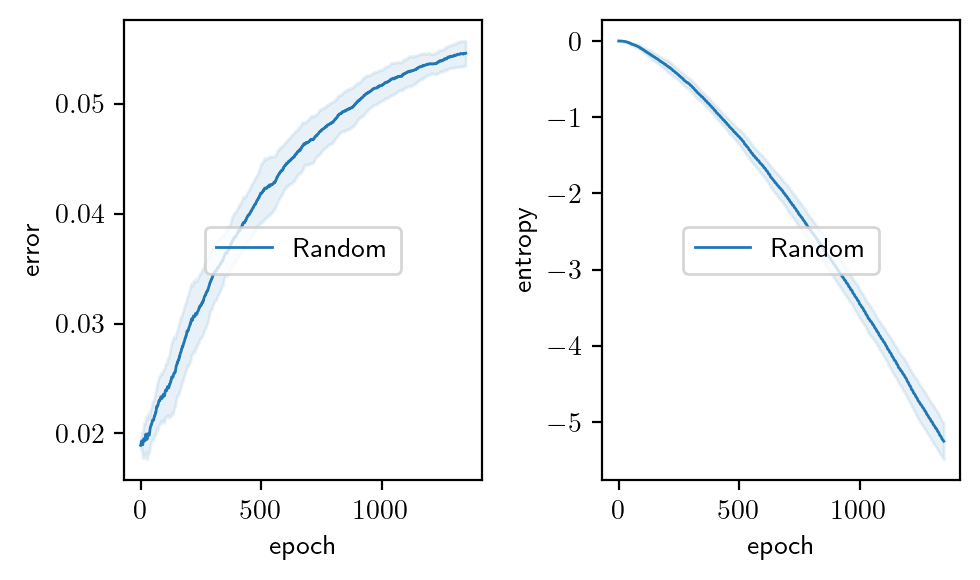

In [129]:
fig, axes = plt.subplots(figsize=(5, 3), ncols=2)
plot.error(run_random, fig=fig, ax=axes[0], ylabel="error")
plot.error(run_random, fig=fig, ax=axes[1], var="mean_ent", ylabel="entropy")

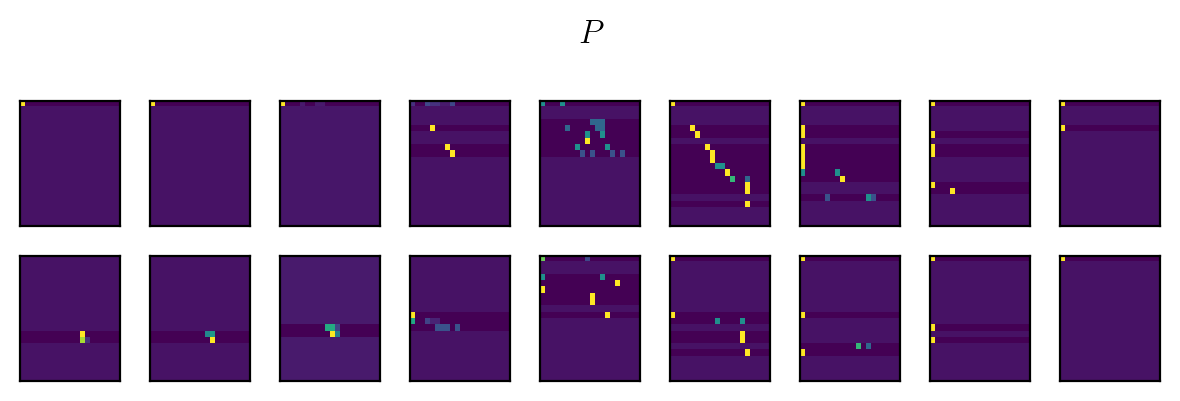

In [130]:
plot.q(transition_velocity_atvv, title="$P$")

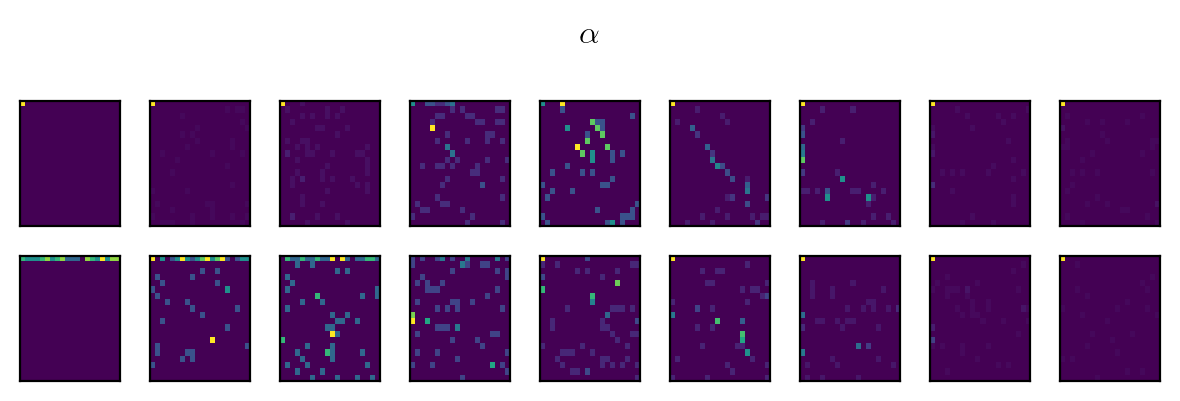

In [131]:
plot.q(alpha_atvv, title=r"$\alpha$")

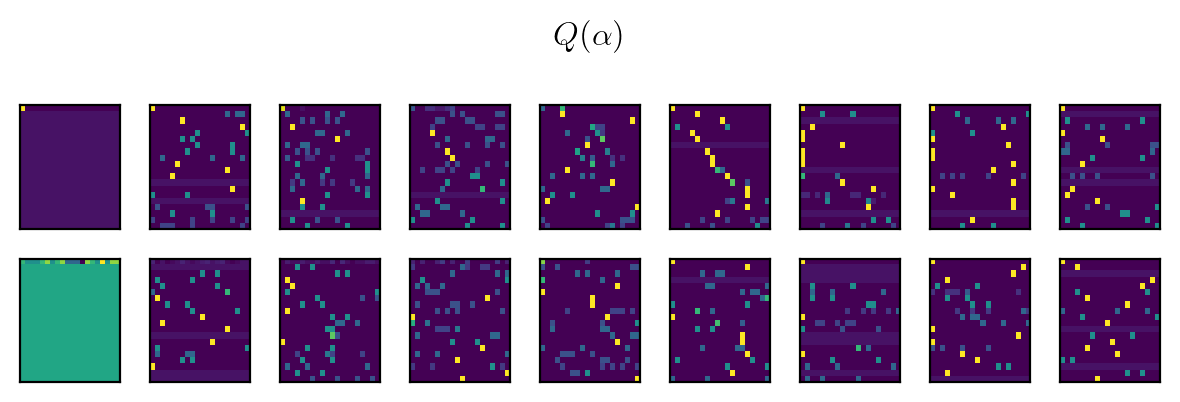

In [132]:
q = normalize_last_dim(alpha_atvv)
plot.q(q, title=r"$Q(\alpha)$")

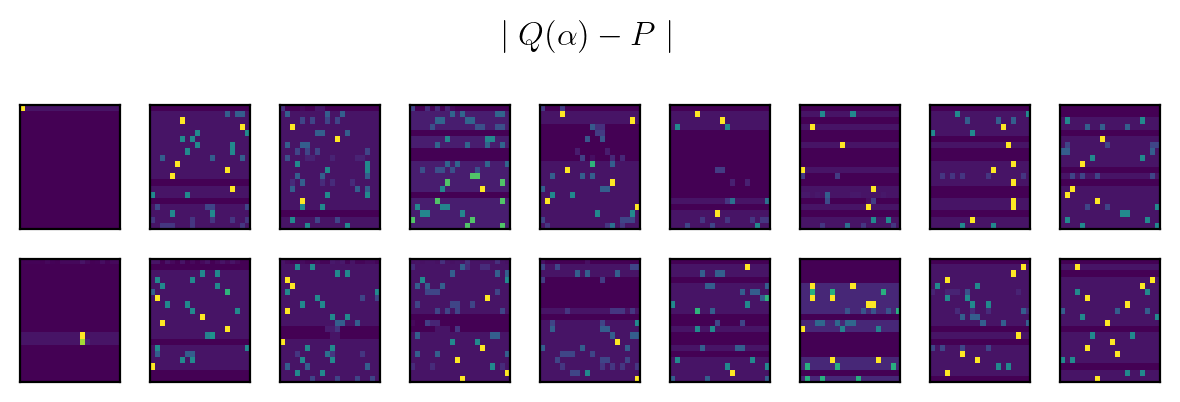

In [133]:
q = normalize_last_dim(alpha_atvv)
diff = np.absolute(transition_velocity_atvv - q)
plot.q(diff, title=r"$\mid Q(\alpha) - P \mid$")

In [134]:
n_episode = 150
n_sample_run = 20
horizon = 1 # len(timestep)
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))
hist_mean_ent = np.zeros_like(hist_err)

for sample in range(n_sample_run):

    # Initialize alpha
    alpha_atvv = np.zeros((n_action, n_timestep, n_velocity, n_velocity)) + np.finfo(np.float64).eps

    # Log error
    error = np.mean(np.absolute(transition_velocity_atvv - normalize_last_dim(alpha_atvv)))
    if sample == 0:
        print(f"Initial error {error:.4f}")

    hist_a = []
    epoch = 0

    # with tqdm(total=n_episode) as pbar:
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin()    # Something close to 0

        for t_idx in range(timestep.size):

            h = min(horizon, n_timestep - t_idx)
            action_plan = list(itertools.product(range(n_action), repeat=h))

            # Initialize action plan values
            pragmatic = np.zeros(len(action_plan))
            epistemic = np.zeros(len(action_plan))

            alpha_t = alpha_atvv.copy()
            qt = normalize_last_dim(alpha_t)
            
            # Compute value of each action plan
            for ap_index, ap in enumerate(action_plan):

                qvs = np.zeros((h, n_velocity))
                qps = np.zeros((h, n_position))
    
                qv = np.zeros(n_velocity)
                qv[v_idx] = 1.
                qp = np.zeros(n_position)
                qp[pos_idx] = 1.
    
                for h_idx in range(h):
                    previous_qv = qv.copy()
                    
                    a = ap[h_idx]
                    rollout_t_index = t_idx + h_idx
                    
                    _qt = qt[a, rollout_t_index]
                    _alpha = alpha_t[a, rollout_t_index]
                    
                    qv = qv @ _qt
                    # qv = qv @ transition_velocity_tavv[rollout_t_index, a, :, :]
                    qp = qp @ (qv @ transition_position_pvp)
                    
                    # Equation B.34 (p 253) 
                    make_sense = _alpha > 0
                    # _alpha += 1e-16
                    # print(np.sum(_qt, axis=-1, keepdims=True))
                    w = 1/(2*_alpha) - 1/(2*np.sum(_alpha, axis=-1, keepdims=True))  
                    w *= make_sense.astype(float)
                    # E_Q[D_KL(Q(o) || Q(o|o'))]
                    v_model = (previous_qv@w)@qv
                    
                    # Eq B.29 (second term is 0 because the entropy of the likelihood matrices is 0)
                    # H(Q(o)) = - sum_i Q(o_i) log(Q(o_i))
                    # Because the likelihood is trivial, Q(o) = Q(s)
                    # For a justification of the epistemic value for state, see p 137
                    # v_state_p = - qp @ np.log(qp + 1e-16) # ---> Add or remove?
                    # v_state_v = - qv @ np.log(qv + 1e-16)
                    
                    # if h_idx == h-1:
                    epistemic[ap_index] += v_model # + v_state_v  # + v_state_p  # + v_model
                    
                    qvs[h_idx] = qv
                    qps[h_idx] = qp
                
                ## Eq B.28
                ## pragmatic[ap_index] = np.sum(qps @ pref)
                
            # Choose the best action plan
            # Use np.allclose instead of == 
            best_action_plan_index = np.random.choice(np.arange(len(action_plan))[epistemic == epistemic.max()])
            a = action_plan[best_action_plan_index][0]

            new_v_index = np.random.choice(n_velocity, p=transition_velocity_atvv[a, t_idx, v_idx, :])

            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            alpha_atvv[a, t_idx, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            pos_idx = np.random.choice(n_position, p=transition_position_pvp[pos_idx, v_idx, :])

            # Log
            error = np.mean(np.absolute(transition_velocity_atvv - normalize_last_dim(alpha_atvv)))
            hist_err[sample, epoch] = error
            hist_a.append(a)
            mean_ent = np.mean(np.sum(-alpha_atvv * np.log(alpha_atvv + 1e-16), axis=-1))
            hist_mean_ent[sample, epoch] = mean_ent
            
            epoch += 1

            # pbar.set_postfix(error=f"{error:.2f}")
            # pbar.update(1)
            
    # print(f"[Sample {sample}] plan {ap} t {h_idx} action {a} v_model {v_model:.2f} v_state_p {v_state_p:.2f} v_state_v {v_state_v:.2f}")

    print(f"[Sample {sample}] Error after {epoch} epochs: {error:.4f}")

    print(f"[Sample {sample}] Freq choose action 0: {100*hist_a.count(0)/len(hist_a):.2f}%")

run_af_epistemic = {"policy": "af-epistemic", "error": hist_err, "mean_ent": hist_mean_ent}

Initial error 0.0190


IndexError: tuple index out of range

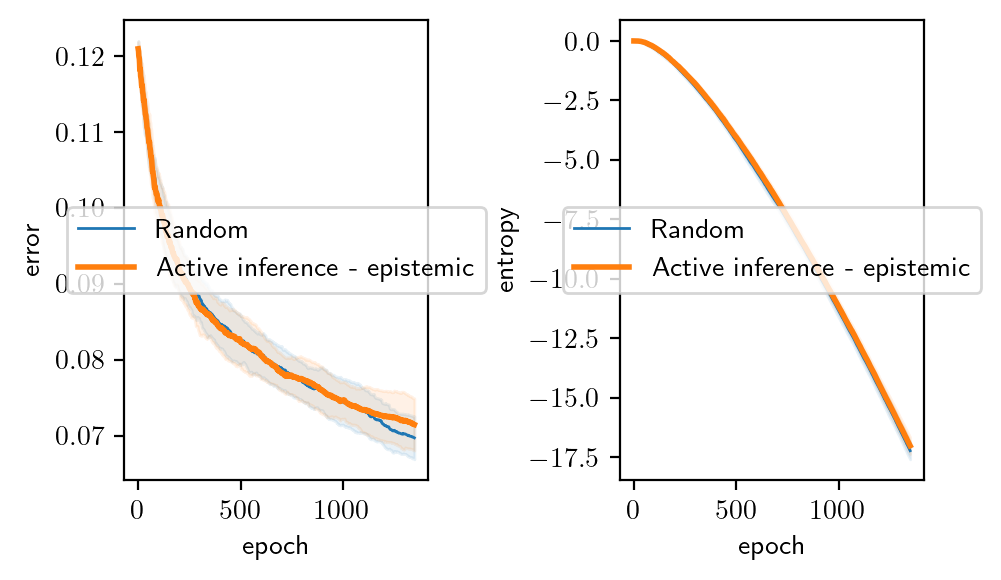

In [38]:
fig, axes = plt.subplots(figsize=(5, 3), ncols=2)
plot.error(run_random, run_af_epistemic, fig=fig, ax=axes[0], ylabel="error")
plot.error(run_random, run_af_epistemic, fig=fig, ax=axes[1], var="mean_ent", ylabel="entropy")

# All together

In [39]:
def run_af(gammas=None, n_episode=150, n_sample=20, horizon=1, verbose=False):
    
    if gammas is None:
        gammas = np.arange(0, 1.2, 0.2)
        
    if verbose:
        pbar = None
    else:
        pbar = tqdm(total=n_episode*len(gammas)*n_sample*n_timestep) 
    
    runs = []
    for gamma_idx, gamma in enumerate(gammas):
        
        hist_err = np.zeros((n_sample, n_episode*n_timestep))
        hist_pos, hist_vel = np.zeros((n_sample, n_episode, n_timestep)), np.zeros((n_sample, n_episode, n_timestep))
        
        for sample in range(n_sample):
        
            # Initialize alpha
            alpha_atvv = np.zeros((n_action, n_timestep, n_velocity, n_velocity)) + np.finfo(np.float64).eps
        
            # Log error
            # error = np.mean(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
            # print(f"[Sample {sample}] Initial error {error:.4f}")
        
            hist_a = []
            epoch = 0
        
            # with tqdm(total=n_episode) as pbar:
            for ep_idx in range(n_episode):
        
                np.random.seed(1234 + ep_idx + sample * 2 + gamma_idx * 3)
        
                pos_idx = np.absolute(position).argmin()  # Something close to 0
                v_idx = np.absolute(velocity).argmin()    # Something close to 0
        
                for t_idx in range(timestep.size):
        
                    h = min(horizon, n_timestep - t_idx)
                    action_plan = list(itertools.product(range(n_action), repeat=h))
        
                    # Initialize action plan values
                    pragmatic = np.zeros(len(action_plan))
                    epistemic = np.zeros(len(action_plan))
        
                    alpha_t = alpha_atvv.copy()
                    qt = normalize_last_dim(alpha_t)
                    
                    # Compute value of each action plan
                    for ap_index, ap in enumerate(action_plan):
        
                        qvs = np.zeros((h, n_velocity))
                        qps = np.zeros((h, n_position))
            
                        qv = np.zeros(n_velocity)
                        qv[v_idx] = 1.
                        qp = np.zeros(n_position)
                        qp[pos_idx] = 1.
            
                        for h_idx in range(h):
                            
                            previous_qv = qv.copy()
                            
                            a = ap[h_idx]
                            rollout_t_index = t_idx + h_idx
                            
                            _qt = qt[a, rollout_t_index]
                            _alpha = alpha_t[a, rollout_t_index]
                            
                            qv = qv @ _qt  # Using beliefs about velocity transitions
                            qp = qp @ (qv @ transition_position_pvp)
                            
                            # Equation B.34 (p 253) 
                            make_sense = _alpha > 0
                            # _qt += 1e-16
                            w = 1/(2*_alpha) - 1/(2*np.sum(_alpha, axis=-1, keepdims=True))  
                            w *= make_sense.astype(float)
                            # E_Q[D_KL(Q(o) || Q(o|o'))]
                            v_model = (previous_qv@w)@qv
                            
                            # Eq B.29
                            # H(Q(o)) = - sum_i Q(o_i) log(Q(o_i)) - E_Q(s)[H[P(o |s)]]
                            # For a justification of the epistemic value for state, see p 137
                            # The second term is 0 because the entropy of the likelihood matrices is 0
                            # Because the likelihood is trivial, Q(o) = Q(s)
                            # v_state_p = - qp @ np.log(qp + 1e-16) # ---> Add or remove?
                            # v_state_v = - qv @ np.log(qv + 1e-16) # ---> Add or remove?
                            # v_state_c = - 0   # Context is known and perfectly predictable in this case
                            
                            # if h_idx == h-1:
                            epistemic[ap_index] += v_model # + v_state_v  # + v_state_p  # + v_model
                            
                            qvs[h_idx] = qv
                            qps[h_idx] = qp
                        
                        # Eq B.28
                        pragmatic[ap_index] = np.sum(qps @ log_prior)
                        
                    # Choose the best action plan
                    efe = gamma*epistemic + pragmatic
                    best_action_plan_index = np.random.choice(np.arange(len(action_plan))[np.isclose(efe, efe.max())])
                    a = action_plan[best_action_plan_index][0]
        
                    new_v_index = np.random.choice(n_velocity, p=transition_velocity_atvv[a, t_idx, v_idx, :])
        
                    # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
                    alpha_atvv[a, t_idx, v_idx, new_v_index] += 1
        
                    # Update velocity and position
                    v_idx = new_v_index
                    pos_idx = np.random.choice(n_position, p=transition_position_pvp[pos_idx, v_idx, :])
        
                    # Log
                    error = np.mean(np.absolute(transition_velocity_atvv - normalize_last_dim(alpha_atvv)))
                    hist_err[sample, epoch] = error
                    hist_pos[sample, ep_idx, t_idx] = position[pos_idx]  
                    hist_vel[sample, ep_idx, t_idx] = velocity[v_idx]
                    hist_a.append(a)
                    epoch += 1
        
                    if pbar is not None:
                        pbar.update(1)

            if verbose:
                print(f"[Sample {sample}] Last position at the last episode {hist_pos[sample, -1, -1]:.2f}")
        
        runs.append({
            "gamma": gamma,
            "policy": "af", 
            "error": hist_err, 
            "position": hist_pos[:, :, :],  
            "velocity": hist_vel[:, :, :]})
    if pbar is not None:
        pbar.close()
    return runs

In [40]:
runs = run_af()

  0%|          | 0/162000 [00:00<?, ?it/s]

In [41]:
best_baseline = [r for r in baselines if r["policy"] == 'max-expected-velocity'][0]
best_baseline__position = best_baseline["position"][:, -1].mean()

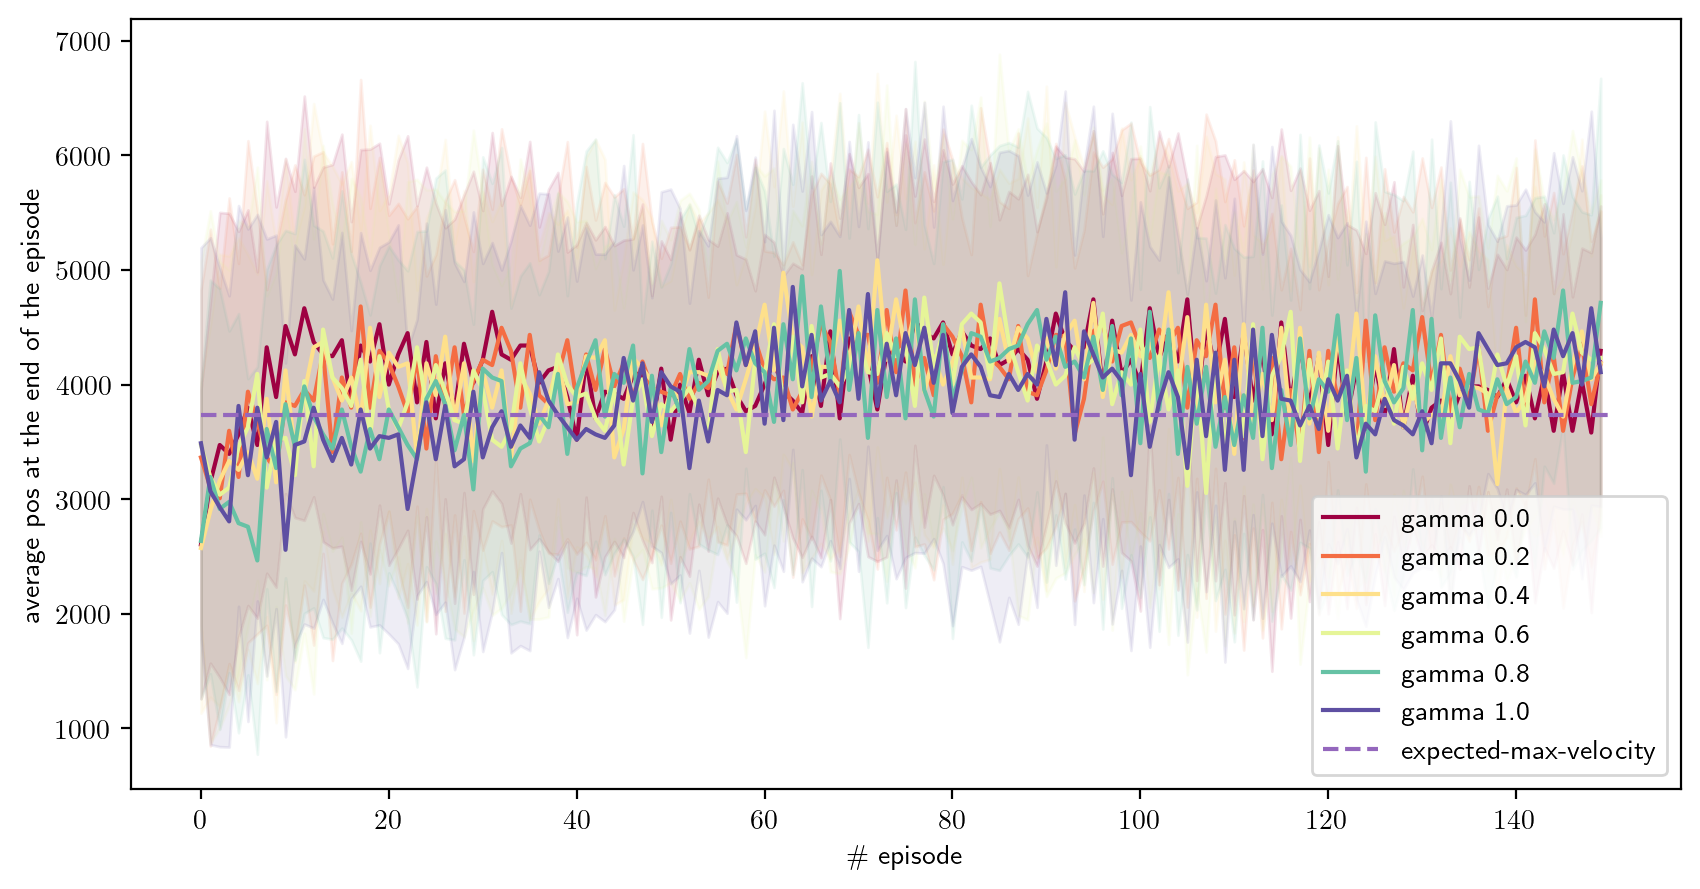

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))

cmap = cm.get_cmap('Spectral')

for i, run in enumerate(runs):
    
    hist_pos = run["position"]
    gamma = run["gamma"]
    
    hist_mean = np.mean(hist_pos[:, :, -1], axis=0)
    hist_std = np.std(hist_pos[:, :, -1], axis=0)
    
    color = cmap(gamma)

    ax.fill_between(np.arange(len(hist_mean)), hist_mean - hist_std, hist_mean + hist_std, alpha=0.1, color=color)
    ax.plot(np.arange(len(hist_mean)), hist_mean, color=color, label=f"gamma {gamma:.1f}")
    
    
ax.hlines(best_baseline__position, 0, runs[0]["position"].shape[1], color="C4", linestyle="--", label="expected-max-velocity")
ax.legend()
ax.set_xlabel(r"\# episode")
ax.set_ylabel("average pos at the end of the episode");

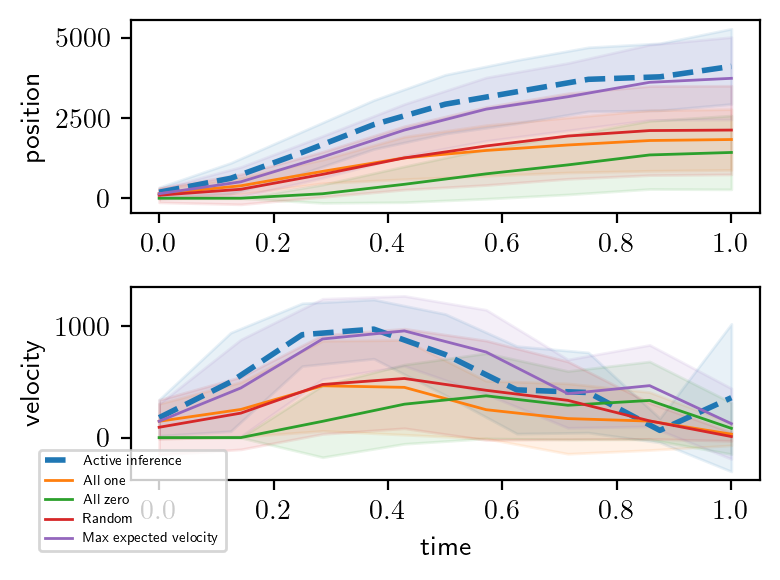

In [43]:
plot.runs(
    [_ for _ in runs if _["gamma"] == 1.0][0], # Run gamma = 1
    *baselines)